<a href="https://colab.research.google.com/github/minhtranhoangnhat/Project_2_CNN/blob/main/NAS_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ------------------------ CÀI ĐẶT ------------------------
!pip install torch torchvision scikit-learn optuna torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 17.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [ ]:
# ------------------------ IMPORT ------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import ParameterGrid
import optuna
from torchinfo import summary
import random
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Subset, random_split
import torch.nn.functional as F

In [ ]:
# ------------------------ DỮ LIỆU ------------------------
# Data augmentation cho tập huấn luyện
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),       # cắt ngẫu nhiên 32x32 sau khi padding
    transforms.RandomHorizontalFlip(),          # lật ngang ngẫu nhiên
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Chỉ chuẩn hóa cho tập validation và test (không augment)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 64

# lấy dữ liệu từ CIFAR-10
full_train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=train_transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=test_transform
)

# chia thành train/val
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# override transform của val_dataset thành test_transform (không augment)
val_dataset.dataset.transform = test_transform

# tạo DataLoaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

100%|██████████| 170M/170M [00:03<00:00, 55.0MB/s]


In [ ]:
# ------------------------ SEARCH SPACE ------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

class SearchSpace:
    def __init__(self):
        self.conv_layers  = [6, 16, 32, 64, 128, 256]
        self.kernel_sizes = [3]

    def sample(self, params):
        num_conv = params['num_conv']  # 2 hoặc 3

        conv_out = []
        # conv1: số kênh output ngẫu nhiên từ 6 đến 64
        conv_out.append(params['conv1_out_channels'])

        # conv2: cố định là 256
        if num_conv >= 2:
            conv_out.append(256)

        # conv3: nếu có, chọn ngẫu nhiên từ conv_layers nhưng khác 256
        if num_conv == 3:
            conv_out.append(random.choice([i for i in self.conv_layers if i != 256]))

        # Kernel size ngẫu nhiên từ danh sách kernel_sizes
        kernel_sizes = [random.choice(self.kernel_sizes) for _ in range(num_conv)]

        class ConvNet(nn.Module):
            def __init__(self):
                super(ConvNet, self).__init__()
                self.convs = nn.ModuleList()
                self.pools = nn.ModuleList()

                in_channels = 3
                self.output_size = 32  # ảnh đầu vào là 32x32

                for i in range(num_conv):
                    k = kernel_sizes[i]
                    out_ch = conv_out[i]
                    self.convs.append(nn.Conv2d(in_channels, out_ch, kernel_size=k, padding=k // 2))

                    # Pool chỉ ở conv1 và conv2
                    if i < 2:
                        self.pools.append(nn.MaxPool2d(2, 2))
                        self.output_size //= 2

                    in_channels = out_ch

                flattened_size = in_channels * self.output_size * self.output_size
                self.fc1 = nn.Linear(flattened_size, params['hidden_units1'])
                self.fc2 = nn.Linear(params['hidden_units1'], params['hidden_units2'])
                self.fc3 = nn.Linear(params['hidden_units2'], 10)

            def forward(self, x):
                for i, conv in enumerate(self.convs):
                    x = F.relu(conv(x))
                    if i < 2:
                        x = self.pools[i](x)
                x = x.view(x.size(0), -1)
                x = F.relu(self.fc1(x))
                x = F.relu(self.fc2(x))
                x = self.fc3(x)
                return x

        return ConvNet()

In [ ]:
# ------------------------ ZERO-COST PROXY ------------------------
def zero_cost_proxy_gradnorm(model, data_loader):
    model.eval()
    model.to(device)

    # Lấy 1 batch đầu tiên từ data_loader
    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)

    # Chỉ dùng 1 mẫu đầu tiên để tiết kiệm tính toán
    dummy_input = images[0].unsqueeze(0)    # shape (1, C, H, W)
    dummy_target = labels[0].unsqueeze(0)   # shape (1,)

    criterion = nn.CrossEntropyLoss()

    model.zero_grad()
    output = model(dummy_input)
    loss = criterion(output, dummy_target)
    loss.backward()

    total_norm = 0.0
    for p in model.parameters():
        if p.grad is not None:
            total_norm += p.grad.norm(2).item() ** 2

    return total_norm ** 0.5


In [ ]:
# ------------------------ HUẤN LUYỆN & ĐÁNH GIÁ ------------------------
def evaluate_architecture(model, epochs, batch_size, lr=0.01):
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    # Initialize data structures for tracking metrics
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_val_accuracy = 0.0  # <-- Track best validation accuracy

    n_total_steps = len(train_loader)

    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0
        running_loss = 0

        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if (i+1) % 2500 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

        # Calculate training metrics
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Evaluation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Update best accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

        # Plotting
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Training Loss', linestyle='-')
        plt.plot(val_losses, label='Validation Loss', linestyle='-')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Loss per Epoch')

        plt.subplot(1, 2, 2)
        plt.plot(train_accuracies, label='Train Accuracy', linestyle='-')
        plt.plot(val_accuracies, label='Validation Accuracy', linestyle='-')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        plt.title('Accuracy per Epoch')

        plt.tight_layout()
        plt.pause(0.1)
        plt.clf()

    print('Finished Training')

    # Return best validation accuracy
    return best_val_accuracy

In [ ]:
# ------------------------ OPTUNA NAS ------------------------
def objective(trial, conv1_out_channels):
    params = {
        'num_conv': trial.suggest_int("num_conv", 2, 3),
        'hidden_units1': trial.suggest_categorical("hidden_units1", [100]),
        'hidden_units2': trial.suggest_categorical("hidden_units2", [50]),
        'conv1_out_channels': conv1_out_channels
    }

    model = SearchSpace().sample(params)

    # In thông tin cấu trúc conv
    print("=== Network Structure ===")
    for i, conv in enumerate(model.convs):
        print(f"Conv{i+1}: in_channels={conv.in_channels}, out_channels={conv.out_channels}, kernel_size={conv.kernel_size}")
        if i < 2:
            print(f" -> MaxPool2d(2,2)")

    print(f"Flattened size: {model.fc1.in_features}")
    print(f"FC1: in={model.fc1.in_features}, out={model.fc1.out_features}")
    print(f"FC2: in={model.fc2.in_features}, out={model.fc2.out_features}")
    print(f"FC3: in={model.fc3.in_features}, out={model.fc3.out_features}")

    # Tính điểm với proxy
    score = zero_cost_proxy_gradnorm(model, train_loader)
    print(f"[Trial] {params} | Proxy Score: {score:.4f} \n")

    return score

[I 2025-06-05 04:52:24,357] A new study created in memory with name: no-name-0b5d102d-82ef-4609-87c4-57dfb607b162
[I 2025-06-05 04:52:24,555] Trial 0 finished with value: 1.1911563297027261 and parameters: {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 1.1911563297027261.


Running Bayesian NAS with Zero-Cost Proxy (GradNorm)...

===== Conv1 Out Channels: 6 =====
=== Network Structure ===
Conv1: in_channels=3, out_channels=6, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=6, out_channels=256, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv3: in_channels=256, out_channels=64, kernel_size=(3, 3)
Flattened size: 4096
FC1: in=4096, out=100
FC2: in=100, out=50
FC3: in=50, out=10
[Trial] {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 6} | Proxy Score: 1.1912 



[I 2025-06-05 04:52:24,565] A new study created in memory with name: no-name-5bb51266-ac8b-41c4-9e54-dd06b6f5e977
[I 2025-06-05 04:52:24,642] Trial 0 finished with value: 2.839085266280118 and parameters: {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 2.839085266280118.
[I 2025-06-05 04:52:24,670] A new study created in memory with name: no-name-9cb80a83-4660-4472-b3b7-634e02cb0e32
[I 2025-06-05 04:52:24,730] Trial 0 finished with value: 1.2742188100521903 and parameters: {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 1.2742188100521903.
[I 2025-06-05 04:52:24,734] A new study created in memory with name: no-name-df9725ad-44da-42fb-afd4-24b47a44f28d



===== Conv1 Out Channels: 7 =====
=== Network Structure ===
Conv1: in_channels=3, out_channels=7, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=7, out_channels=256, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Flattened size: 16384
FC1: in=16384, out=100
FC2: in=100, out=50
FC3: in=50, out=10
[Trial] {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 7} | Proxy Score: 2.8391 


===== Conv1 Out Channels: 8 =====
=== Network Structure ===
Conv1: in_channels=3, out_channels=8, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=8, out_channels=256, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv3: in_channels=256, out_channels=64, kernel_size=(3, 3)
Flattened size: 4096
FC1: in=4096, out=100
FC2: in=100, out=50
FC3: in=50, out=10
[Trial] {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 8} | Proxy Score: 1.2742 


===== Conv1 Out Channels: 9 =====
=== Network Structure ===
Conv1: in_channels=3, out_channels=9, kernel_size=(

[I 2025-06-05 04:52:24,816] Trial 0 finished with value: 2.918453704472234 and parameters: {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 2.918453704472234.
[I 2025-06-05 04:52:24,844] A new study created in memory with name: no-name-f39067ea-7dd2-43a3-9592-a9a60e1371e0
[I 2025-06-05 04:52:24,939] Trial 0 finished with value: 2.6436116011316644 and parameters: {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 2.6436116011316644.
[I 2025-06-05 04:52:24,940] A new study created in memory with name: no-name-93191c5a-cac3-49b4-b798-7f89d72ea043


[Trial] {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 9} | Proxy Score: 2.9185 


===== Conv1 Out Channels: 10 =====
=== Network Structure ===
Conv1: in_channels=3, out_channels=10, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=10, out_channels=256, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Flattened size: 16384
FC1: in=16384, out=100
FC2: in=100, out=50
FC3: in=50, out=10
[Trial] {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 10} | Proxy Score: 2.6436 


===== Conv1 Out Channels: 11 =====
=== Network Structure ===
Conv1: in_channels=3, out_channels=11, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=11, out_channels=256, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Flattened size: 16384
FC1: in=16384, out=100
FC2: in=100, out=50
FC3: in=50, out=10


[I 2025-06-05 04:52:25,029] Trial 0 finished with value: 3.1232554947173545 and parameters: {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 3.1232554947173545.
[I 2025-06-05 04:52:25,055] A new study created in memory with name: no-name-6da11143-fdf6-4e41-9a50-44675b6752ca
[I 2025-06-05 04:52:25,164] Trial 0 finished with value: 1.5875596222091388 and parameters: {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 1.5875596222091388.
[I 2025-06-05 04:52:25,171] A new study created in memory with name: no-name-86e24041-090a-4c63-a301-c1378910dafa


[Trial] {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 11} | Proxy Score: 3.1233 


===== Conv1 Out Channels: 12 =====
=== Network Structure ===
Conv1: in_channels=3, out_channels=12, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=12, out_channels=256, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv3: in_channels=256, out_channels=64, kernel_size=(3, 3)
Flattened size: 4096
FC1: in=4096, out=100
FC2: in=100, out=50
FC3: in=50, out=10
[Trial] {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 12} | Proxy Score: 1.5876 


===== Conv1 Out Channels: 13 =====


[I 2025-06-05 04:52:25,333] Trial 0 finished with value: 3.7078843382463478 and parameters: {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 3.7078843382463478.
[I 2025-06-05 04:52:25,399] A new study created in memory with name: no-name-dd06d714-1caa-4573-9739-3a3b73541f0d


=== Network Structure ===
Conv1: in_channels=3, out_channels=13, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=13, out_channels=256, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Flattened size: 16384
FC1: in=16384, out=100
FC2: in=100, out=50
FC3: in=50, out=10
[Trial] {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 13} | Proxy Score: 3.7079 


===== Conv1 Out Channels: 14 =====
=== Network Structure ===
Conv1: in_channels=3, out_channels=14, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=14, out_channels=256, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Flattened size: 16384
FC1: in=16384, out=100
FC2: in=100, out=50
FC3: in=50, out=10


[I 2025-06-05 04:52:25,485] Trial 0 finished with value: 3.237402836576275 and parameters: {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 3.237402836576275.
[I 2025-06-05 04:52:25,489] A new study created in memory with name: no-name-2ab7ecdf-3d69-4a36-9a29-ab8af9845fb9
[I 2025-06-05 04:52:25,554] Trial 0 finished with value: 1.5308122525737036 and parameters: {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 1.5308122525737036.
[I 2025-06-05 04:52:25,559] A new study created in memory with name: no-name-70f120b1-b66b-484a-b1b1-76a5531488c3
[I 2025-06-05 04:52:25,638] Trial 0 finished with value: 1.3361044864704439 and parameters: {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 1.3361044864704439.
[I 2025-06-05 04:52:25,643] A new study created in memory with name: no-name-dec6f049-7450-43b0-ab25-327bf3164716


[Trial] {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 14} | Proxy Score: 3.2374 


===== Conv1 Out Channels: 15 =====
=== Network Structure ===
Conv1: in_channels=3, out_channels=15, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=15, out_channels=256, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv3: in_channels=256, out_channels=64, kernel_size=(3, 3)
Flattened size: 4096
FC1: in=4096, out=100
FC2: in=100, out=50
FC3: in=50, out=10
[Trial] {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 15} | Proxy Score: 1.5308 


===== Conv1 Out Channels: 16 =====
=== Network Structure ===
Conv1: in_channels=3, out_channels=16, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=16, out_channels=256, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv3: in_channels=256, out_channels=128, kernel_size=(3, 3)
Flattened size: 8192
FC1: in=8192, out=100
FC2: in=100, out=50
FC3: in=50, out=10
[Trial] {'num_conv': 3, 'hidden_units1': 100,

[I 2025-06-05 04:52:25,715] Trial 0 finished with value: 1.1753996564868712 and parameters: {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 1.1753996564868712.
[I 2025-06-05 04:52:25,721] A new study created in memory with name: no-name-69b99f1b-db78-4c4f-b961-07b7a964309b
[I 2025-06-05 04:52:25,824] Trial 0 finished with value: 2.641569722411237 and parameters: {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 2.641569722411237.
[I 2025-06-05 04:52:25,829] A new study created in memory with name: no-name-6c6b63a5-d31b-4acd-9bf6-6f359aa11507
[I 2025-06-05 04:52:25,900] Trial 0 finished with value: 1.2297953340890782 and parameters: {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 1.2297953340890782.
[I 2025-06-05 04:52:25,904] A new study created in memory with name: no-name-01eb7cca-e71a-49a4-9613-6e88c33be358


[Trial] {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 17} | Proxy Score: 1.1754 


===== Conv1 Out Channels: 18 =====
=== Network Structure ===
Conv1: in_channels=3, out_channels=18, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=18, out_channels=256, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Flattened size: 16384
FC1: in=16384, out=100
FC2: in=100, out=50
FC3: in=50, out=10
[Trial] {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 18} | Proxy Score: 2.6416 


===== Conv1 Out Channels: 19 =====
=== Network Structure ===
Conv1: in_channels=3, out_channels=19, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=19, out_channels=256, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv3: in_channels=256, out_channels=32, kernel_size=(3, 3)
Flattened size: 2048
FC1: in=2048, out=100
FC2: in=100, out=50
FC3: in=50, out=10
[Trial] {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 19} | Proxy Sco

[I 2025-06-05 04:52:25,981] Trial 0 finished with value: 3.4369404627540106 and parameters: {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 3.4369404627540106.
[I 2025-06-05 04:52:25,987] A new study created in memory with name: no-name-738038cb-cedd-4bd6-9c5c-0293aa0c347e
[I 2025-06-05 04:52:26,064] Trial 0 finished with value: 2.651575762772699 and parameters: {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 2.651575762772699.
[I 2025-06-05 04:52:26,069] A new study created in memory with name: no-name-0fb89258-31e5-448c-a779-fa7e5bd3ba7f


=== Network Structure ===
Conv1: in_channels=3, out_channels=20, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=20, out_channels=256, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Flattened size: 16384
FC1: in=16384, out=100
FC2: in=100, out=50
FC3: in=50, out=10
[Trial] {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 20} | Proxy Score: 3.4369 


===== Conv1 Out Channels: 21 =====
=== Network Structure ===
Conv1: in_channels=3, out_channels=21, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=21, out_channels=256, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Flattened size: 16384
FC1: in=16384, out=100
FC2: in=100, out=50
FC3: in=50, out=10
[Trial] {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 21} | Proxy Score: 2.6516 


===== Conv1 Out Channels: 22 =====
=== Network Structure ===
Conv1: in_channels=3, out_channels=22, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=22, out_channels=256, kernel_size=(3, 3)

[I 2025-06-05 04:52:26,144] Trial 0 finished with value: 1.320731569348467 and parameters: {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 1.320731569348467.
[I 2025-06-05 04:52:26,150] A new study created in memory with name: no-name-0bc57f4b-6bff-4ecf-94bd-48411f1730d1
[I 2025-06-05 04:52:26,204] Trial 0 finished with value: 1.139152759680977 and parameters: {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 1.139152759680977.
[I 2025-06-05 04:52:26,209] A new study created in memory with name: no-name-c1ddf528-ac22-4300-9ae6-5af2c2bad12c
[I 2025-06-05 04:52:26,303] Trial 0 finished with value: 2.7907214351751484 and parameters: {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 2.7907214351751484.
[I 2025-06-05 04:52:26,309] A new study created in memory with name: no-name-7e07a3f2-2a66-49e8-a93c-fc972e34b7c1


[Trial] {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 22} | Proxy Score: 1.3207 


===== Conv1 Out Channels: 23 =====
=== Network Structure ===
Conv1: in_channels=3, out_channels=23, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=23, out_channels=256, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv3: in_channels=256, out_channels=16, kernel_size=(3, 3)
Flattened size: 1024
FC1: in=1024, out=100
FC2: in=100, out=50
FC3: in=50, out=10
[Trial] {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 23} | Proxy Score: 1.1392 


===== Conv1 Out Channels: 24 =====
=== Network Structure ===
Conv1: in_channels=3, out_channels=24, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=24, out_channels=256, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Flattened size: 16384
FC1: in=16384, out=100
FC2: in=100, out=50
FC3: in=50, out=10
[Trial] {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 24} | Proxy Sco

[I 2025-06-05 04:52:26,397] Trial 0 finished with value: 3.0253893807398566 and parameters: {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 3.0253893807398566.
[I 2025-06-05 04:52:26,402] A new study created in memory with name: no-name-7f711135-57fa-44be-a305-f09e48f5c316
[I 2025-06-05 04:52:26,504] Trial 0 finished with value: 2.664206387573147 and parameters: {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 2.664206387573147.
[I 2025-06-05 04:52:26,509] A new study created in memory with name: no-name-79294559-c006-4c62-8100-77a05cda0225


=== Network Structure ===
Conv1: in_channels=3, out_channels=25, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=25, out_channels=256, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Flattened size: 16384
FC1: in=16384, out=100
FC2: in=100, out=50
FC3: in=50, out=10
[Trial] {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 25} | Proxy Score: 3.0254 


===== Conv1 Out Channels: 26 =====
=== Network Structure ===
Conv1: in_channels=3, out_channels=26, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=26, out_channels=256, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Flattened size: 16384
FC1: in=16384, out=100
FC2: in=100, out=50
FC3: in=50, out=10
[Trial] {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 26} | Proxy Score: 2.6642 


===== Conv1 Out Channels: 27 =====
=== Network Structure ===
Conv1: in_channels=3, out_channels=27, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=27, out_channels=256, kernel_size=(3, 3)

[I 2025-06-05 04:52:26,595] Trial 0 finished with value: 2.3741389711316785 and parameters: {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 2.3741389711316785.
[I 2025-06-05 04:52:26,600] A new study created in memory with name: no-name-4cbf6ba5-0d73-4481-9b9c-a0245bfd1efd
[I 2025-06-05 04:52:26,701] Trial 0 finished with value: 2.489362285492721 and parameters: {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 2.489362285492721.
[I 2025-06-05 04:52:26,709] A new study created in memory with name: no-name-d9241676-a934-43c4-a0eb-8547d3e745a4
[I 2025-06-05 04:52:26,789] Trial 0 finished with value: 1.189519073513287 and parameters: {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 1.189519073513287.
[I 2025-06-05 04:52:26,790] A new study created in memory with name: no-name-26c1a701-9402-4e2c-ae7b-64d9a386e8d1


[Trial] {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 27} | Proxy Score: 2.3741 


===== Conv1 Out Channels: 28 =====
=== Network Structure ===
Conv1: in_channels=3, out_channels=28, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=28, out_channels=256, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Flattened size: 16384
FC1: in=16384, out=100
FC2: in=100, out=50
FC3: in=50, out=10
[Trial] {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 28} | Proxy Score: 2.4894 


===== Conv1 Out Channels: 29 =====
=== Network Structure ===
Conv1: in_channels=3, out_channels=29, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=29, out_channels=256, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv3: in_channels=256, out_channels=32, kernel_size=(3, 3)
Flattened size: 2048
FC1: in=2048, out=100
FC2: in=100, out=50
FC3: in=50, out=10
[Trial] {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 29} | Proxy Sco

[I 2025-06-05 04:52:26,844] Trial 0 finished with value: 1.2255549136486266 and parameters: {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 1.2255549136486266.
[I 2025-06-05 04:52:26,846] A new study created in memory with name: no-name-73b85c70-88a7-4fe2-adbc-2dac9cd6ea86
[I 2025-06-05 04:52:26,900] Trial 0 finished with value: 1.1442047408268075 and parameters: {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 1.1442047408268075.
[I 2025-06-05 04:52:26,902] A new study created in memory with name: no-name-092f20cf-e0dd-436e-a73d-c3d86fdb1718
[I 2025-06-05 04:52:26,990] Trial 0 finished with value: 1.3485659850513914 and parameters: {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 1.3485659850513914.
[I 2025-06-05 04:52:26,992] A new study created in memory with name: no-name-27ca0089-5cf6-4b21-a37e-0cfd5efaf9b7


=== Network Structure ===
Conv1: in_channels=3, out_channels=30, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=30, out_channels=256, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv3: in_channels=256, out_channels=32, kernel_size=(3, 3)
Flattened size: 2048
FC1: in=2048, out=100
FC2: in=100, out=50
FC3: in=50, out=10
[Trial] {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 30} | Proxy Score: 1.2256 


===== Conv1 Out Channels: 31 =====
=== Network Structure ===
Conv1: in_channels=3, out_channels=31, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=31, out_channels=256, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv3: in_channels=256, out_channels=6, kernel_size=(3, 3)
Flattened size: 384
FC1: in=384, out=100
FC2: in=100, out=50
FC3: in=50, out=10
[Trial] {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 31} | Proxy Score: 1.1442 


===== Conv1 Out Channels: 32 =====
=== Network Structure ===
Conv1: in_channels=3, o

[I 2025-06-05 04:52:27,099] Trial 0 finished with value: 3.1527132481833746 and parameters: {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 3.1527132481833746.
[I 2025-06-05 04:52:27,105] A new study created in memory with name: no-name-fb6d4c55-95cc-403b-b5e8-d0d0129a03ea


=== Network Structure ===
Conv1: in_channels=3, out_channels=33, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=33, out_channels=256, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Flattened size: 16384
FC1: in=16384, out=100
FC2: in=100, out=50
FC3: in=50, out=10
[Trial] {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 33} | Proxy Score: 3.1527 


===== Conv1 Out Channels: 34 =====
=== Network Structure ===
Conv1: in_channels=3, out_channels=34, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=34, out_channels=256, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv3: in_channels=256, out_channels=64, kernel_size=(3, 3)
Flattened size: 4096
FC1: in=4096, out=100
FC2: in=100, out=50
FC3: in=50, out=10


[I 2025-06-05 04:52:27,225] Trial 0 finished with value: 1.22928924922362 and parameters: {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 1.22928924922362.
[I 2025-06-05 04:52:27,227] A new study created in memory with name: no-name-b8a76cc4-58d7-4ad1-b6ad-5a4dbacf4519
[I 2025-06-05 04:52:27,337] Trial 0 finished with value: 3.1990154404052182 and parameters: {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 3.1990154404052182.
[I 2025-06-05 04:52:27,338] A new study created in memory with name: no-name-295b7bd9-fa3c-48b8-a8d8-f7a9afe38de2
[I 2025-06-05 04:52:27,377] Trial 0 finished with value: 1.132639078497469 and parameters: {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 1.132639078497469.
[I 2025-06-05 04:52:27,378] A new study created in memory with name: no-name-7b5fa2ee-6d26-4fd6-8fc2-fadc465b7e2e
[I 2025-06-05 04:52:27,418] Trial 0 finished with value: 1.12179

[Trial] {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 34} | Proxy Score: 1.2293 


===== Conv1 Out Channels: 35 =====
=== Network Structure ===
Conv1: in_channels=3, out_channels=35, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=35, out_channels=256, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Flattened size: 16384
FC1: in=16384, out=100
FC2: in=100, out=50
FC3: in=50, out=10
[Trial] {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 35} | Proxy Score: 3.1990 


===== Conv1 Out Channels: 36 =====
=== Network Structure ===
Conv1: in_channels=3, out_channels=36, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=36, out_channels=256, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv3: in_channels=256, out_channels=32, kernel_size=(3, 3)
Flattened size: 2048
FC1: in=2048, out=100
FC2: in=100, out=50
FC3: in=50, out=10
[Trial] {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 36} | Proxy Sco

[I 2025-06-05 04:52:27,478] Trial 0 finished with value: 1.3511759887503767 and parameters: {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 1.3511759887503767.
[I 2025-06-05 04:52:27,479] A new study created in memory with name: no-name-fce13770-1d18-4464-bcb1-207381efeb46
[I 2025-06-05 04:52:27,523] Trial 0 finished with value: 1.2247069952082374 and parameters: {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 1.2247069952082374.
[I 2025-06-05 04:52:27,525] A new study created in memory with name: no-name-e9aa3ae3-236d-4e06-b83a-ca9817ac78d5
[I 2025-06-05 04:52:27,571] Trial 0 finished with value: 1.5451067242674836 and parameters: {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 1.5451067242674836.
[I 2025-06-05 04:52:27,573] A new study created in memory with name: no-name-bbf77de8-edc6-4f06-b977-0a57a11fa0d8
[I 2025-06-05 04:52:27,623] Trial 0 finished with value: 3

=== Network Structure ===
Conv1: in_channels=3, out_channels=38, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=38, out_channels=256, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv3: in_channels=256, out_channels=128, kernel_size=(3, 3)
Flattened size: 8192
FC1: in=8192, out=100
FC2: in=100, out=50
FC3: in=50, out=10
[Trial] {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 38} | Proxy Score: 1.3512 


===== Conv1 Out Channels: 39 =====
=== Network Structure ===
Conv1: in_channels=3, out_channels=39, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=39, out_channels=256, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv3: in_channels=256, out_channels=64, kernel_size=(3, 3)
Flattened size: 4096
FC1: in=4096, out=100
FC2: in=100, out=50
FC3: in=50, out=10
[Trial] {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 39} | Proxy Score: 1.2247 


===== Conv1 Out Channels: 40 =====
=== Network Structure ===
Conv1: in_channels=

[I 2025-06-05 04:52:27,676] Trial 0 finished with value: 1.806351530737481 and parameters: {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 1.806351530737481.
[I 2025-06-05 04:52:27,678] A new study created in memory with name: no-name-263bfe28-ef1c-4519-bae4-3e327a17171e
[I 2025-06-05 04:52:27,725] Trial 0 finished with value: 3.803860093300354 and parameters: {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 3.803860093300354.
[I 2025-06-05 04:52:27,742] A new study created in memory with name: no-name-670cdadd-0325-445c-b61e-0c855a444be8
[I 2025-06-05 04:52:27,789] Trial 0 finished with value: 1.1292954342901838 and parameters: {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 1.1292954342901838.
[I 2025-06-05 04:52:27,790] A new study created in memory with name: no-name-e3d4131d-57b4-4932-be3c-a8c7c2ac164c
[I 2025-06-05 04:52:27,841] Trial 0 finished with value: 3.011

=== Network Structure ===
Conv1: in_channels=3, out_channels=42, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=42, out_channels=256, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Flattened size: 16384
FC1: in=16384, out=100
FC2: in=100, out=50
FC3: in=50, out=10
[Trial] {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 42} | Proxy Score: 1.8064 


===== Conv1 Out Channels: 43 =====
=== Network Structure ===
Conv1: in_channels=3, out_channels=43, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=43, out_channels=256, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Flattened size: 16384
FC1: in=16384, out=100
FC2: in=100, out=50
FC3: in=50, out=10
[Trial] {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 43} | Proxy Score: 3.8039 


===== Conv1 Out Channels: 44 =====
=== Network Structure ===
Conv1: in_channels=3, out_channels=44, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=44, out_channels=256, kernel_size=(3, 3)

[I 2025-06-05 04:52:27,892] Trial 0 finished with value: 2.362189201915269 and parameters: {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 2.362189201915269.
[I 2025-06-05 04:52:27,893] A new study created in memory with name: no-name-d581e051-f339-48d7-a11d-64473426e0b4
[I 2025-06-05 04:52:27,946] Trial 0 finished with value: 1.3723544552693332 and parameters: {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 1.3723544552693332.
[I 2025-06-05 04:52:27,947] A new study created in memory with name: no-name-a0479474-f77f-4cdd-a0e4-65ba211c5087
[I 2025-06-05 04:52:27,997] Trial 0 finished with value: 2.253597428186841 and parameters: {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 2.253597428186841.
[I 2025-06-05 04:52:27,999] A new study created in memory with name: no-name-b5d46270-ec3b-4ec4-af5f-086a64ef465a
[I 2025-06-05 04:52:28,048] Trial 0 finished with value: 3.631

=== Network Structure ===
Conv1: in_channels=3, out_channels=46, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=46, out_channels=256, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Flattened size: 16384
FC1: in=16384, out=100
FC2: in=100, out=50
FC3: in=50, out=10
[Trial] {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 46} | Proxy Score: 2.3622 


===== Conv1 Out Channels: 47 =====
=== Network Structure ===
Conv1: in_channels=3, out_channels=47, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=47, out_channels=256, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv3: in_channels=256, out_channels=128, kernel_size=(3, 3)
Flattened size: 8192
FC1: in=8192, out=100
FC2: in=100, out=50
FC3: in=50, out=10
[Trial] {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 47} | Proxy Score: 1.3724 


===== Conv1 Out Channels: 48 =====
=== Network Structure ===
Conv1: in_channels=3, out_channels=48, kernel_size=(3, 3)
 -> MaxPool2d(2,2)


[I 2025-06-05 04:52:28,098] Trial 0 finished with value: 1.2352062118171745 and parameters: {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 1.2352062118171745.
[I 2025-06-05 04:52:28,099] A new study created in memory with name: no-name-5c72dfb0-f057-4852-9387-c0a0eb230b0b
[I 2025-06-05 04:52:28,142] Trial 0 finished with value: 1.284924384737615 and parameters: {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 1.284924384737615.
[I 2025-06-05 04:52:28,143] A new study created in memory with name: no-name-48a98195-c7cc-48fa-a91a-7ad1d217bb6d
[I 2025-06-05 04:52:28,199] Trial 0 finished with value: 2.266131317675718 and parameters: {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 2.266131317675718.
[I 2025-06-05 04:52:28,200] A new study created in memory with name: no-name-e03a4fb4-25b3-41cd-9915-c253cca3ae4b
[I 2025-06-05 04:52:28,246] Trial 0 finished with value: 1.508

=== Network Structure ===
Conv1: in_channels=3, out_channels=50, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=50, out_channels=256, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv3: in_channels=256, out_channels=128, kernel_size=(3, 3)
Flattened size: 8192
FC1: in=8192, out=100
FC2: in=100, out=50
FC3: in=50, out=10
[Trial] {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 50} | Proxy Score: 1.2352 


===== Conv1 Out Channels: 51 =====
=== Network Structure ===
Conv1: in_channels=3, out_channels=51, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=51, out_channels=256, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv3: in_channels=256, out_channels=32, kernel_size=(3, 3)
Flattened size: 2048
FC1: in=2048, out=100
FC2: in=100, out=50
FC3: in=50, out=10
[Trial] {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 51} | Proxy Score: 1.2849 


===== Conv1 Out Channels: 52 =====
=== Network Structure ===
Conv1: in_channels=

[I 2025-06-05 04:52:28,303] Trial 0 finished with value: 2.8403173089570966 and parameters: {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 2.8403173089570966.
[I 2025-06-05 04:52:28,306] A new study created in memory with name: no-name-c8a330d2-9c16-429f-a441-0629ab41d539
[I 2025-06-05 04:52:28,353] Trial 0 finished with value: 1.4672951386052406 and parameters: {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 1.4672951386052406.
[I 2025-06-05 04:52:28,355] A new study created in memory with name: no-name-fb013130-29c9-4de1-bc73-5b962eabae75
[I 2025-06-05 04:52:28,405] Trial 0 finished with value: 3.2909318182310905 and parameters: {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 3.2909318182310905.
[I 2025-06-05 04:52:28,406] A new study created in memory with name: no-name-780c71b8-5d3c-4f58-a11e-223954bec45c
[I 2025-06-05 04:52:28,460] Trial 0 finished with value: 2

=== Network Structure ===
Conv1: in_channels=3, out_channels=54, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=54, out_channels=256, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Flattened size: 16384
FC1: in=16384, out=100
FC2: in=100, out=50
FC3: in=50, out=10
[Trial] {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 54} | Proxy Score: 2.8403 


===== Conv1 Out Channels: 55 =====
=== Network Structure ===
Conv1: in_channels=3, out_channels=55, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=55, out_channels=256, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv3: in_channels=256, out_channels=128, kernel_size=(3, 3)
Flattened size: 8192
FC1: in=8192, out=100
FC2: in=100, out=50
FC3: in=50, out=10
[Trial] {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 55} | Proxy Score: 1.4673 


===== Conv1 Out Channels: 56 =====
=== Network Structure ===
Conv1: in_channels=3, out_channels=56, kernel_size=(3, 3)
 -> MaxPool2d(2,2)


[I 2025-06-05 04:52:28,531] Trial 0 finished with value: 3.185921045689 and parameters: {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 3.185921045689.
[I 2025-06-05 04:52:28,532] A new study created in memory with name: no-name-302b6979-26f1-4ebe-8e68-fcf47ae12a24
[I 2025-06-05 04:52:28,586] Trial 0 finished with value: 2.4909436977226496 and parameters: {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 2.4909436977226496.
[I 2025-06-05 04:52:28,587] A new study created in memory with name: no-name-b33d4555-0e9c-44ec-a408-d7ce1ade6970
[I 2025-06-05 04:52:28,639] Trial 0 finished with value: 2.465179425661825 and parameters: {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 2.465179425661825.
[I 2025-06-05 04:52:28,640] A new study created in memory with name: no-name-2113e3e0-eaeb-4a82-87c0-4cc2ff6a6fd3


=== Network Structure ===
Conv1: in_channels=3, out_channels=58, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=58, out_channels=256, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Flattened size: 16384
FC1: in=16384, out=100
FC2: in=100, out=50
FC3: in=50, out=10
[Trial] {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 58} | Proxy Score: 3.1859 


===== Conv1 Out Channels: 59 =====
=== Network Structure ===
Conv1: in_channels=3, out_channels=59, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=59, out_channels=256, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Flattened size: 16384
FC1: in=16384, out=100
FC2: in=100, out=50
FC3: in=50, out=10
[Trial] {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 59} | Proxy Score: 2.4909 


===== Conv1 Out Channels: 60 =====
=== Network Structure ===
Conv1: in_channels=3, out_channels=60, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=60, out_channels=256, kernel_size=(3, 3)

[I 2025-06-05 04:52:28,697] Trial 0 finished with value: 2.3505232193333696 and parameters: {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 2.3505232193333696.
[I 2025-06-05 04:52:28,698] A new study created in memory with name: no-name-f1102020-d880-4d79-ad06-150290d20f74
[I 2025-06-05 04:52:28,749] Trial 0 finished with value: 3.361131543133914 and parameters: {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 3.361131543133914.
[I 2025-06-05 04:52:28,751] A new study created in memory with name: no-name-287b5635-5156-4758-845e-edec4c0e7ba3
[I 2025-06-05 04:52:28,789] Trial 0 finished with value: 1.1458145344936579 and parameters: {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50}. Best is trial 0 with value: 1.1458145344936579.
[I 2025-06-05 04:52:28,791] A new study created in memory with name: no-name-a05feb27-b77a-46c3-adce-842b263d4e97
[I 2025-06-05 04:52:28,831] Trial 0 finished with value: 1.2

[Trial] {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 61} | Proxy Score: 2.3505 


===== Conv1 Out Channels: 62 =====
=== Network Structure ===
Conv1: in_channels=3, out_channels=62, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=62, out_channels=256, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Flattened size: 16384
FC1: in=16384, out=100
FC2: in=100, out=50
FC3: in=50, out=10
[Trial] {'num_conv': 2, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 62} | Proxy Score: 3.3611 


===== Conv1 Out Channels: 63 =====
=== Network Structure ===
Conv1: in_channels=3, out_channels=63, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv2: in_channels=63, out_channels=256, kernel_size=(3, 3)
 -> MaxPool2d(2,2)
Conv3: in_channels=256, out_channels=16, kernel_size=(3, 3)
Flattened size: 1024
FC1: in=1024, out=100
FC2: in=100, out=50
FC3: in=50, out=10
[Trial] {'num_conv': 3, 'hidden_units1': 100, 'hidden_units2': 50, 'conv1_out_channels': 63} | Proxy Sco

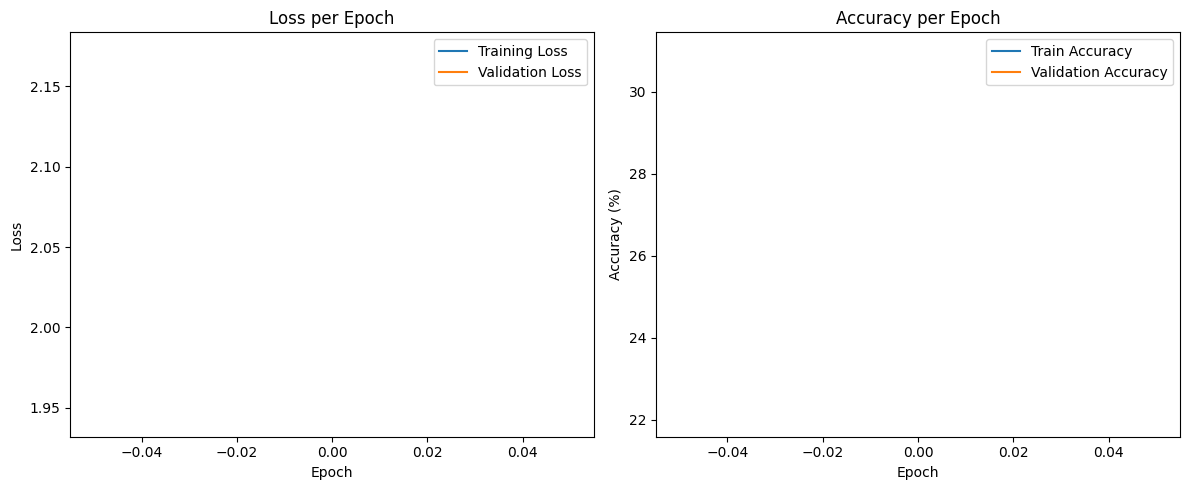

Epoch [2/60], Train Loss: 1.8052, Train Accuracy: 35.17%, Val Loss: 1.6761, Val Accuracy: 39.76%


<Figure size 640x480 with 0 Axes>

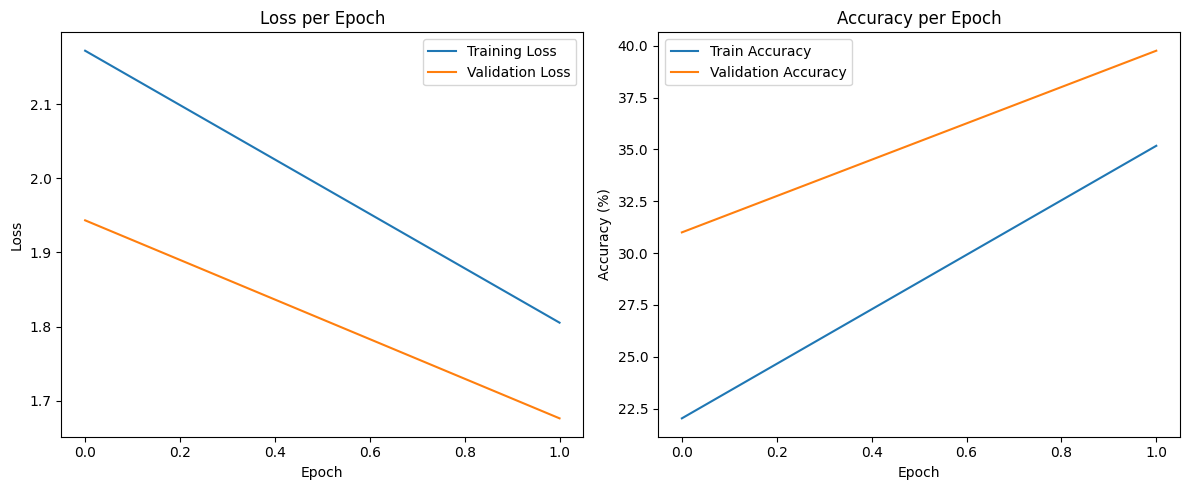

Epoch [3/60], Train Loss: 1.5923, Train Accuracy: 42.57%, Val Loss: 1.5333, Val Accuracy: 45.28%


<Figure size 640x480 with 0 Axes>

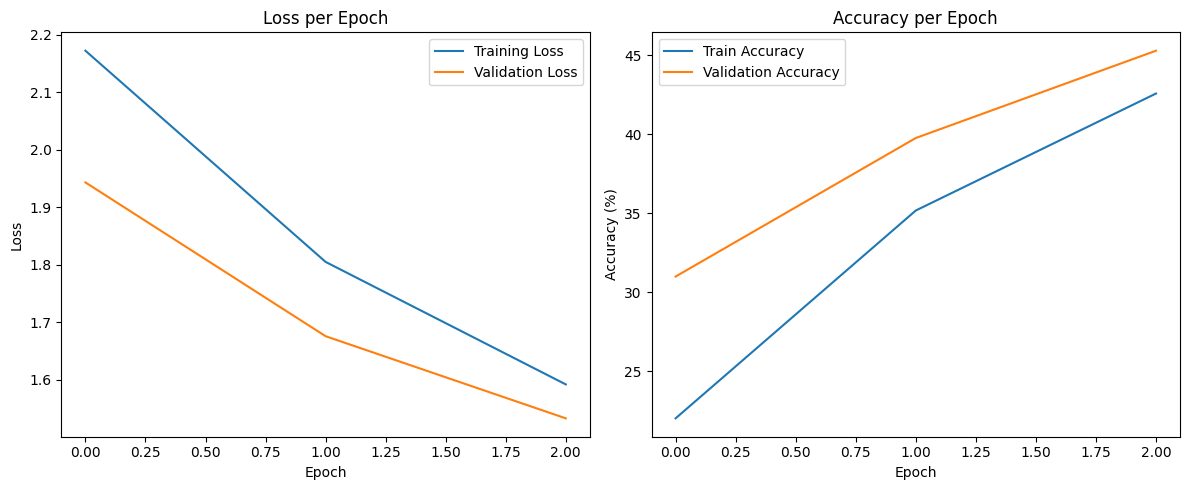

Epoch [4/60], Train Loss: 1.4557, Train Accuracy: 47.44%, Val Loss: 1.4311, Val Accuracy: 47.92%


<Figure size 640x480 with 0 Axes>

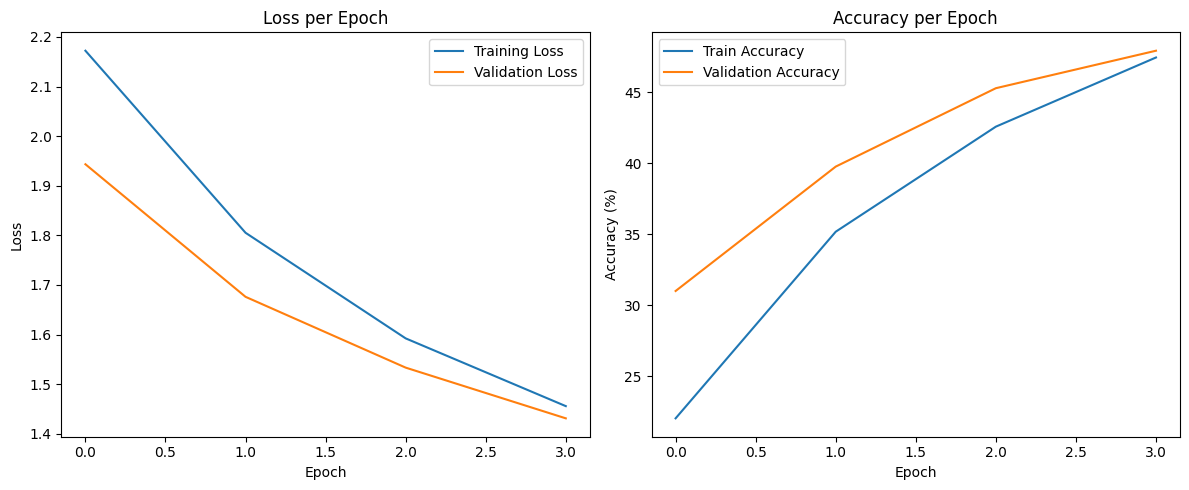

Epoch [5/60], Train Loss: 1.3590, Train Accuracy: 50.96%, Val Loss: 1.3344, Val Accuracy: 51.82%


<Figure size 640x480 with 0 Axes>

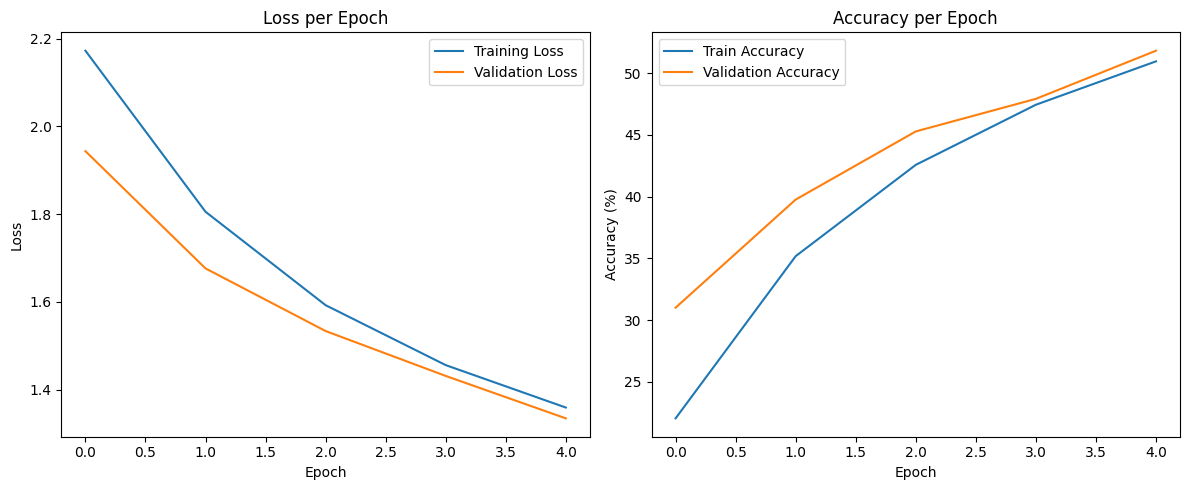

Epoch [6/60], Train Loss: 1.2822, Train Accuracy: 54.00%, Val Loss: 1.2583, Val Accuracy: 55.25%


<Figure size 640x480 with 0 Axes>

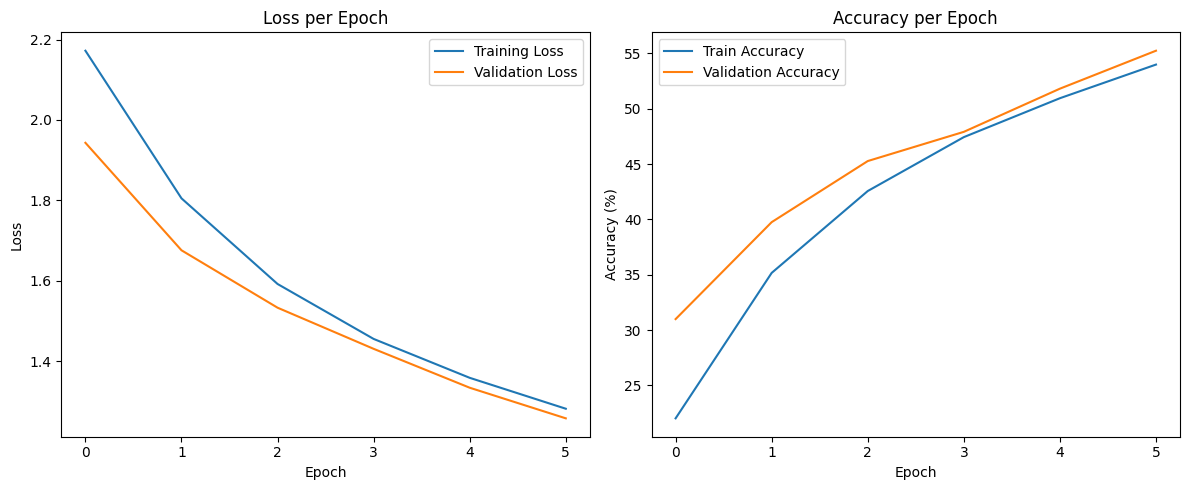

Epoch [7/60], Train Loss: 1.2130, Train Accuracy: 56.53%, Val Loss: 1.1869, Val Accuracy: 58.08%


<Figure size 640x480 with 0 Axes>

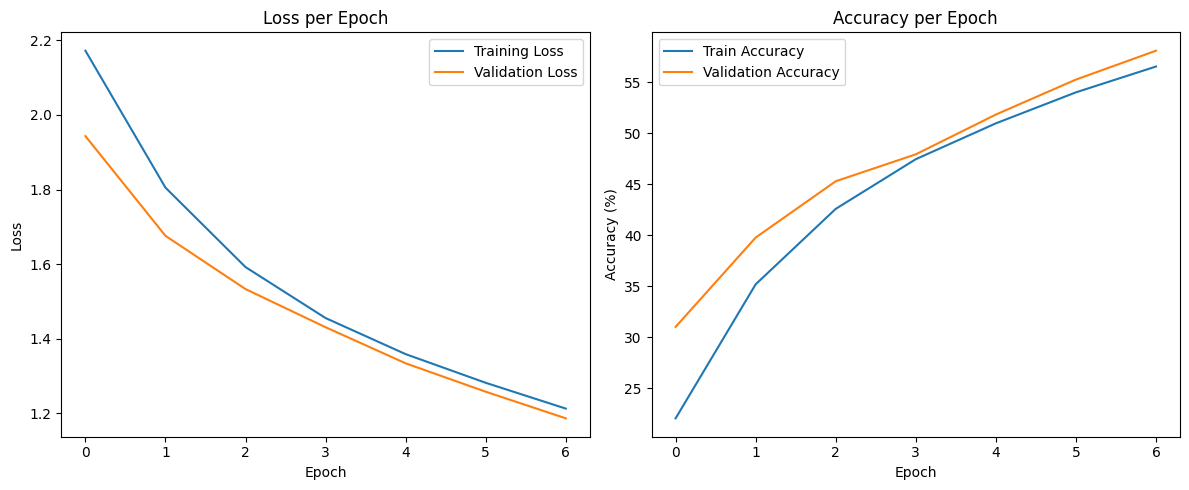

Epoch [8/60], Train Loss: 1.1479, Train Accuracy: 59.12%, Val Loss: 1.2423, Val Accuracy: 56.42%


<Figure size 640x480 with 0 Axes>

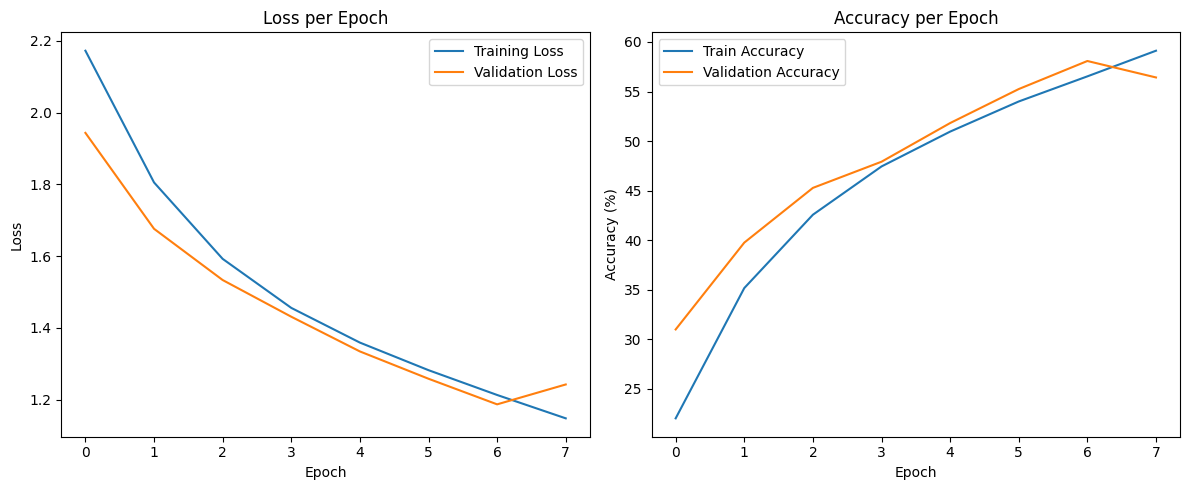

Epoch [9/60], Train Loss: 1.0876, Train Accuracy: 61.38%, Val Loss: 1.1334, Val Accuracy: 60.22%


<Figure size 640x480 with 0 Axes>

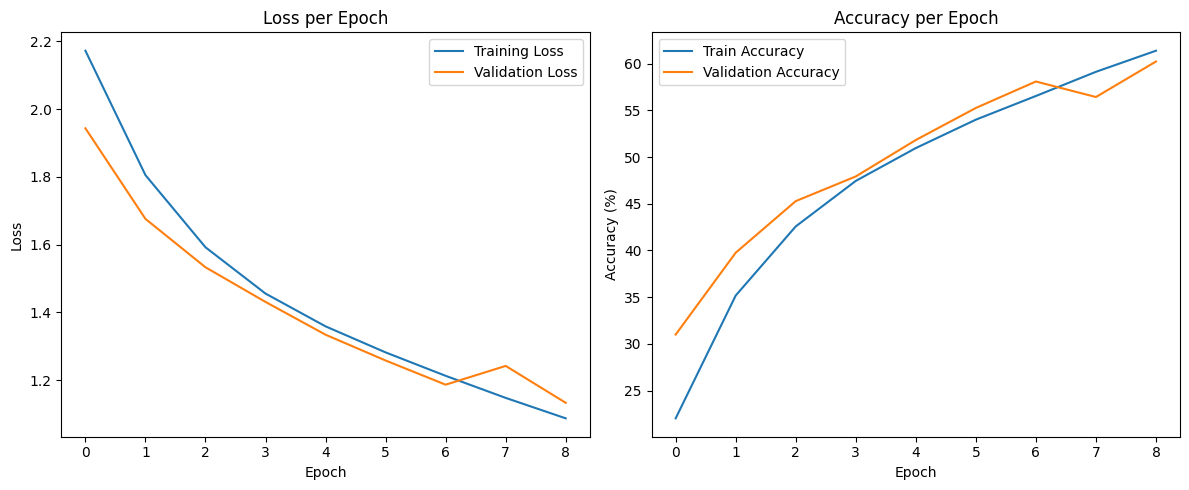

Epoch [10/60], Train Loss: 1.0352, Train Accuracy: 63.39%, Val Loss: 1.0836, Val Accuracy: 62.00%


<Figure size 640x480 with 0 Axes>

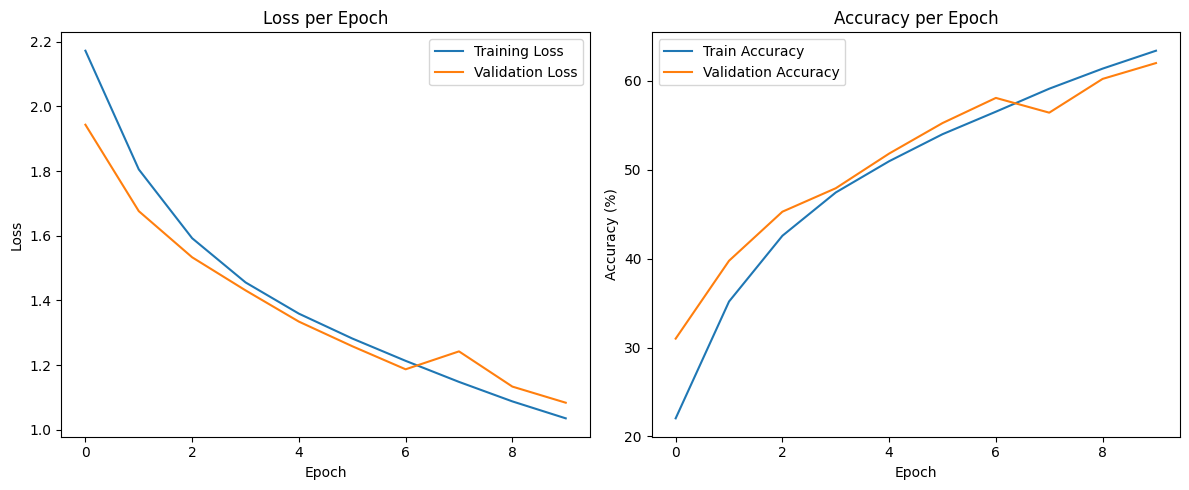

Epoch [11/60], Train Loss: 0.9859, Train Accuracy: 65.25%, Val Loss: 1.0251, Val Accuracy: 64.33%


<Figure size 640x480 with 0 Axes>

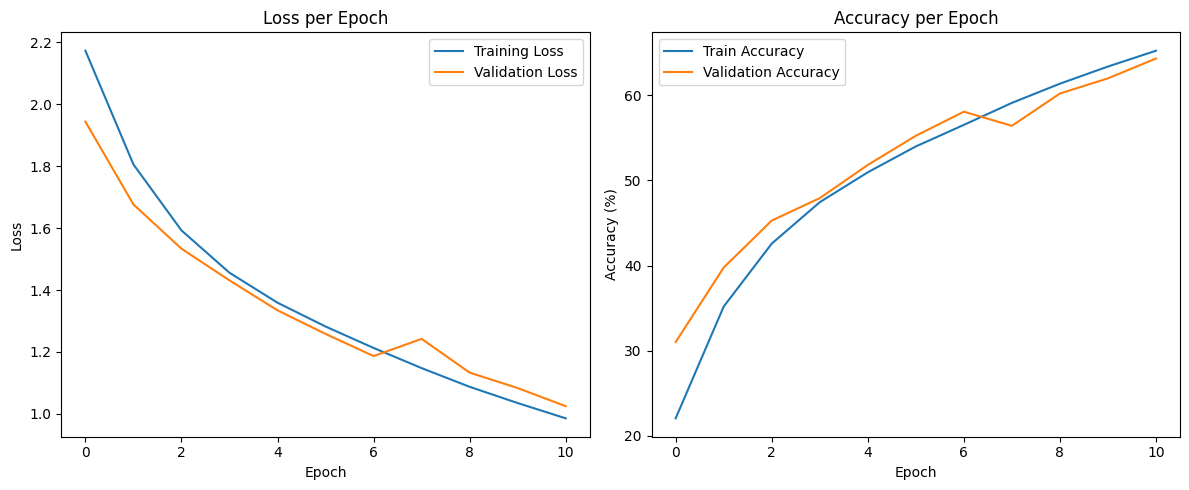

Epoch [12/60], Train Loss: 0.9400, Train Accuracy: 66.86%, Val Loss: 1.0170, Val Accuracy: 64.55%


<Figure size 640x480 with 0 Axes>

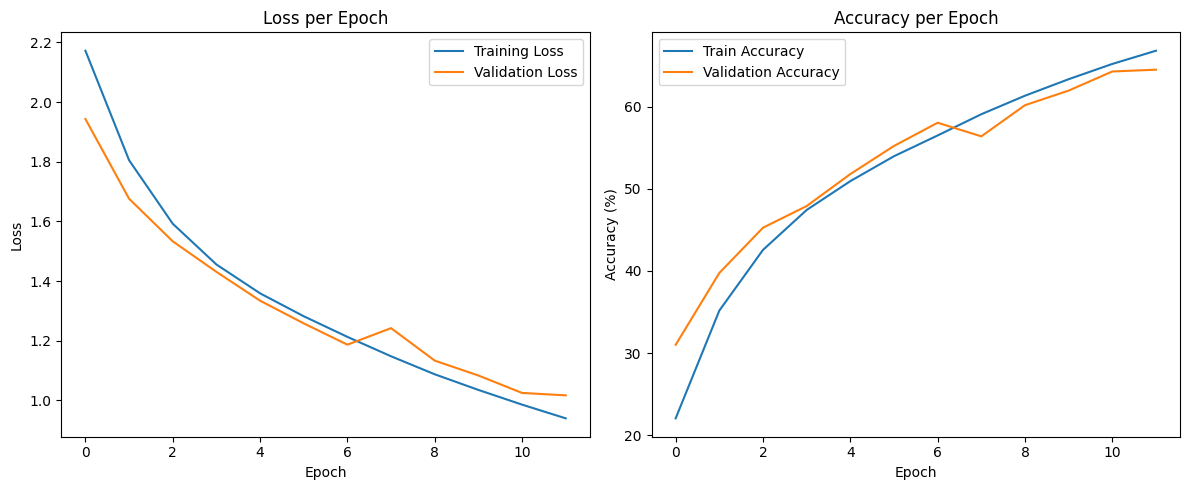

Epoch [13/60], Train Loss: 0.8950, Train Accuracy: 68.52%, Val Loss: 0.9738, Val Accuracy: 66.04%


<Figure size 640x480 with 0 Axes>

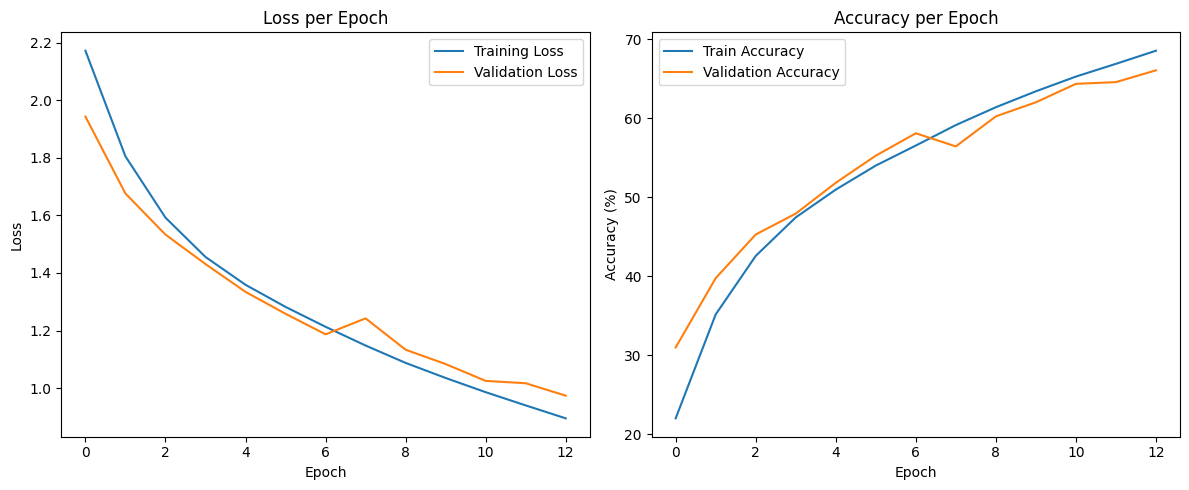

Epoch [14/60], Train Loss: 0.8556, Train Accuracy: 69.93%, Val Loss: 0.9723, Val Accuracy: 66.69%


<Figure size 640x480 with 0 Axes>

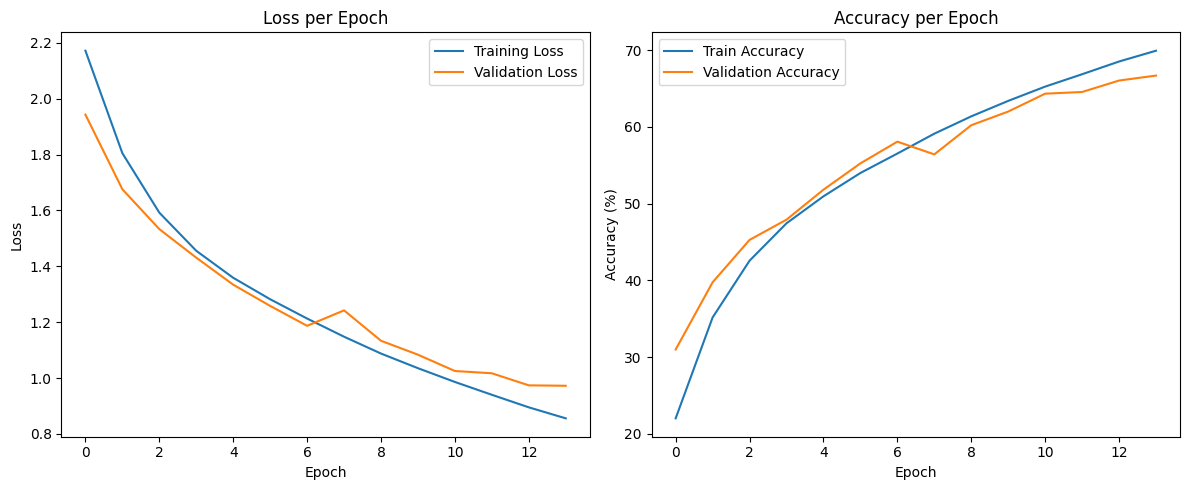

Epoch [15/60], Train Loss: 0.8157, Train Accuracy: 71.37%, Val Loss: 0.9598, Val Accuracy: 66.95%


<Figure size 640x480 with 0 Axes>

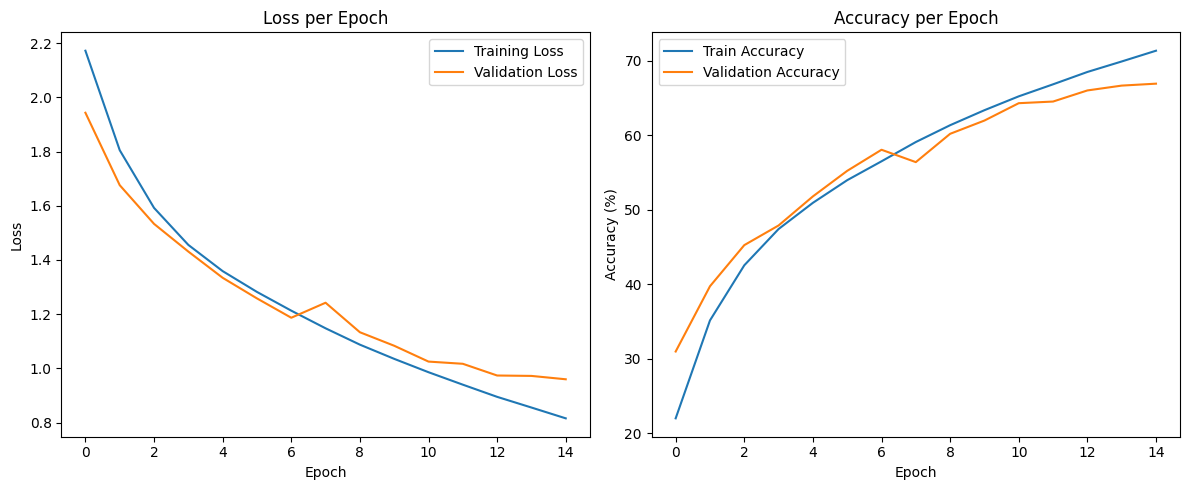

Epoch [16/60], Train Loss: 0.7799, Train Accuracy: 72.75%, Val Loss: 0.9491, Val Accuracy: 67.38%


<Figure size 640x480 with 0 Axes>

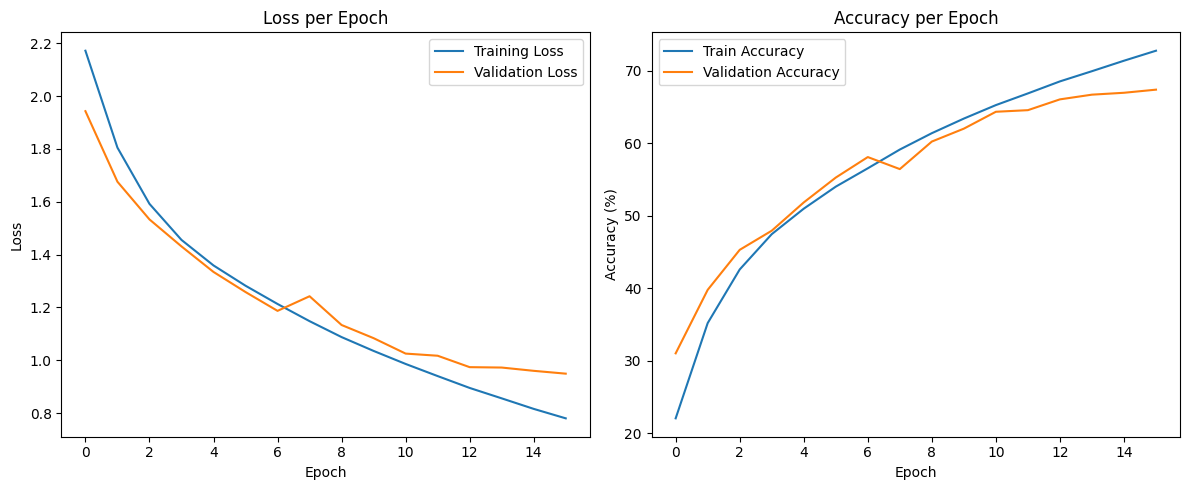

Epoch [17/60], Train Loss: 0.7406, Train Accuracy: 73.95%, Val Loss: 0.8948, Val Accuracy: 69.39%


<Figure size 640x480 with 0 Axes>

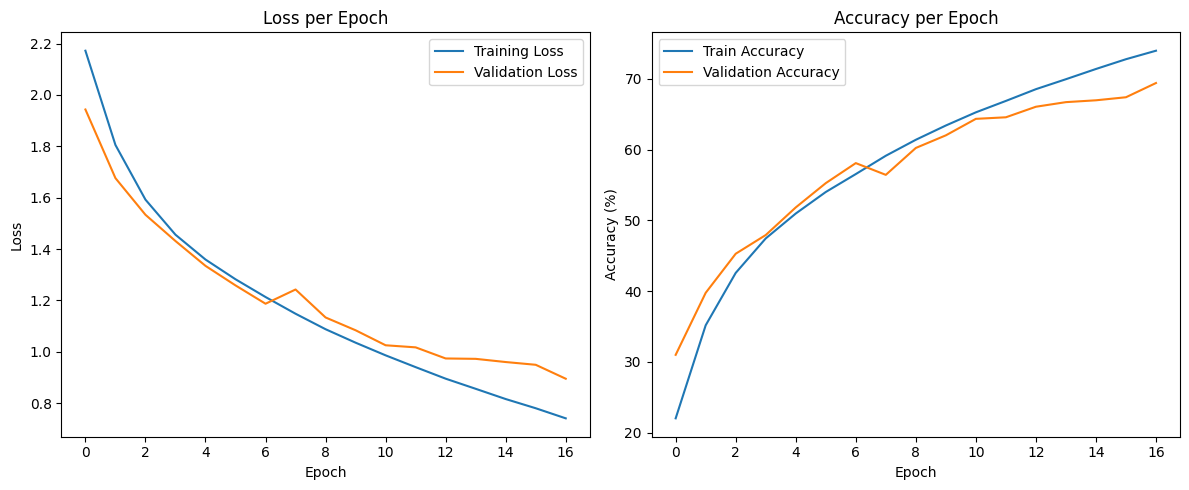

Epoch [18/60], Train Loss: 0.7037, Train Accuracy: 75.44%, Val Loss: 0.9318, Val Accuracy: 68.29%


<Figure size 640x480 with 0 Axes>

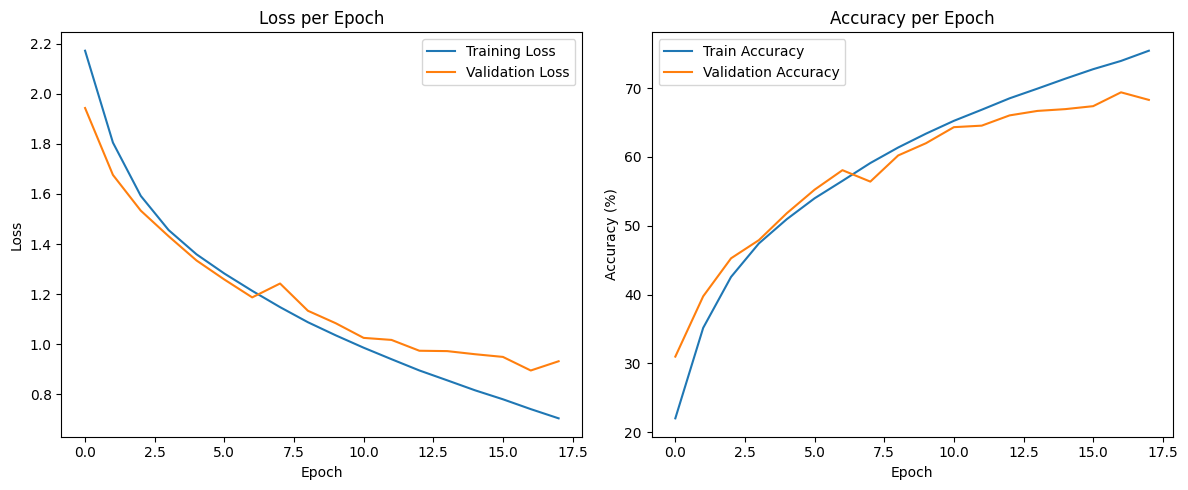

Epoch [19/60], Train Loss: 0.6678, Train Accuracy: 76.66%, Val Loss: 0.8783, Val Accuracy: 69.79%


<Figure size 640x480 with 0 Axes>

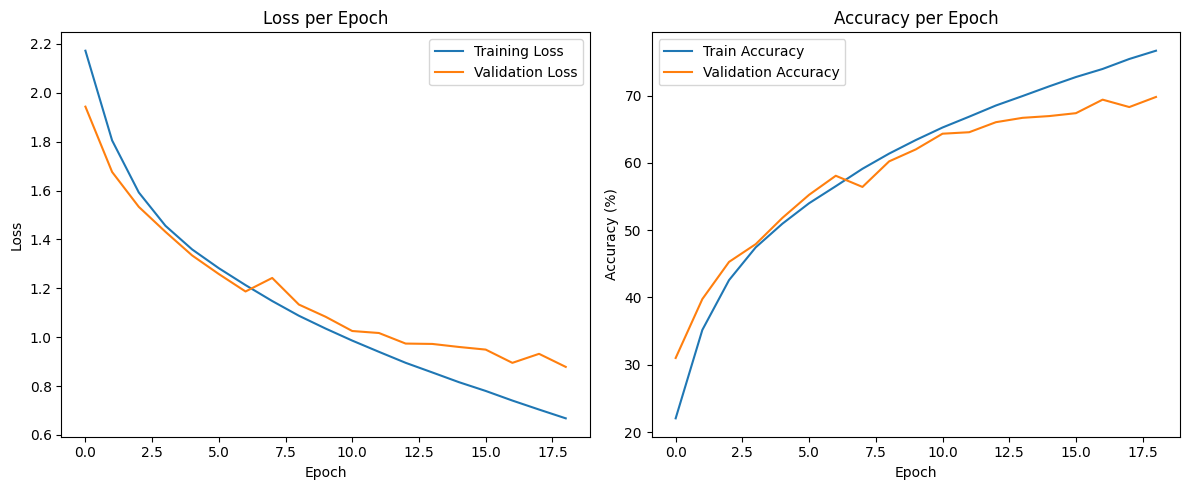

Epoch [20/60], Train Loss: 0.6307, Train Accuracy: 78.12%, Val Loss: 0.8657, Val Accuracy: 70.78%


<Figure size 640x480 with 0 Axes>

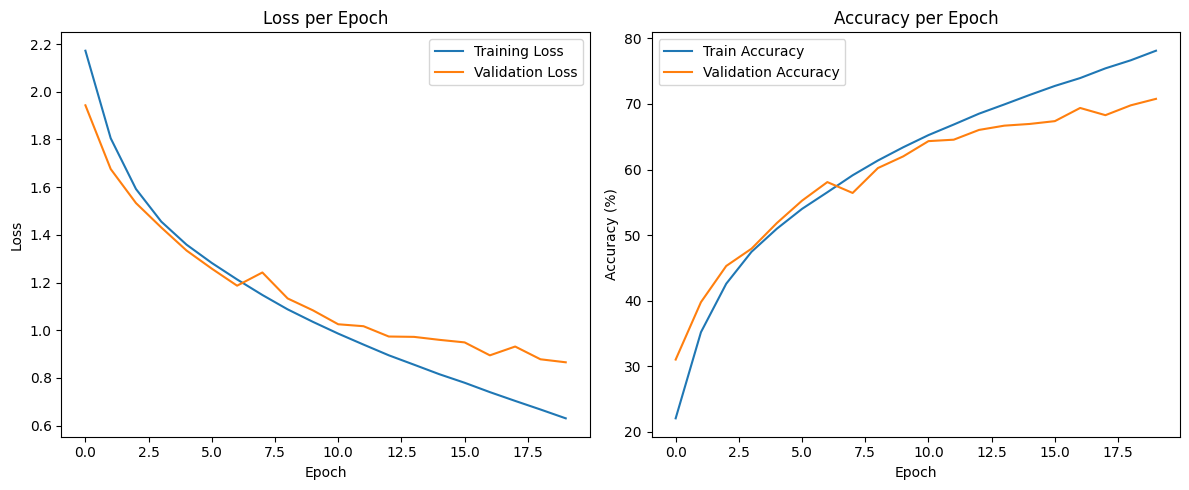

Epoch [21/60], Train Loss: 0.5941, Train Accuracy: 79.38%, Val Loss: 0.9712, Val Accuracy: 67.57%


<Figure size 640x480 with 0 Axes>

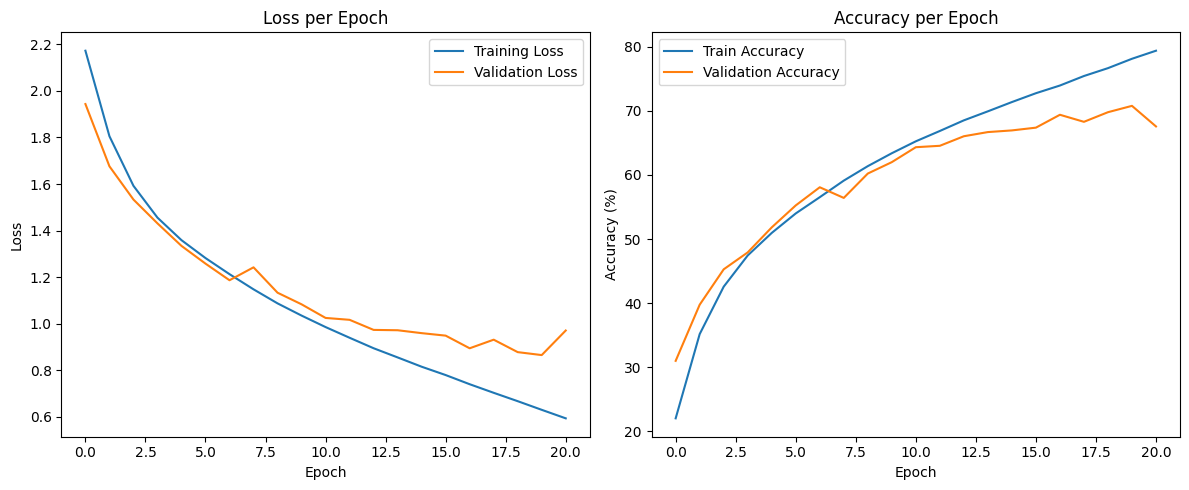

Epoch [22/60], Train Loss: 0.5563, Train Accuracy: 80.88%, Val Loss: 0.8640, Val Accuracy: 71.29%


<Figure size 640x480 with 0 Axes>

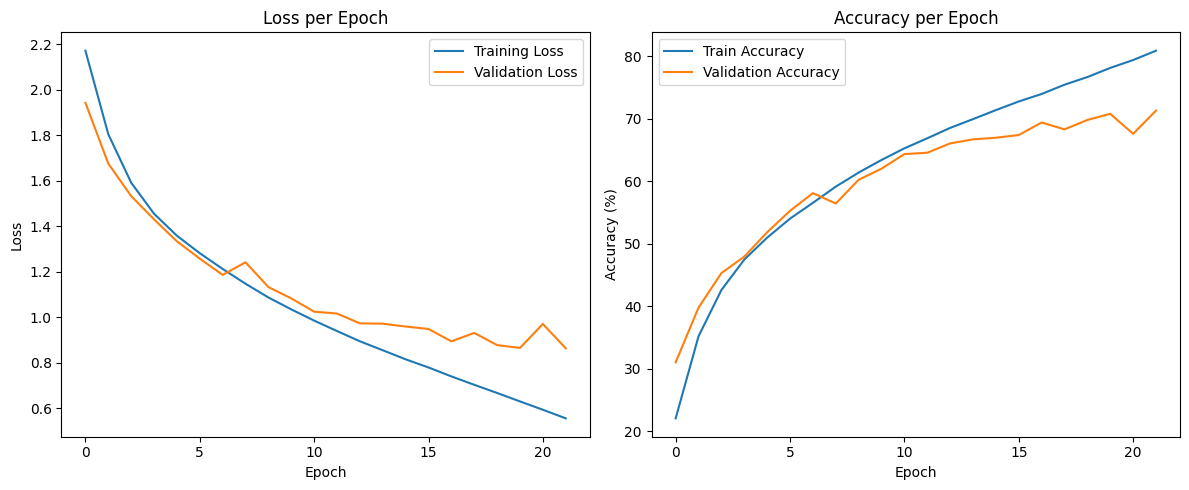

Epoch [23/60], Train Loss: 0.5190, Train Accuracy: 82.00%, Val Loss: 0.8812, Val Accuracy: 70.64%


<Figure size 640x480 with 0 Axes>

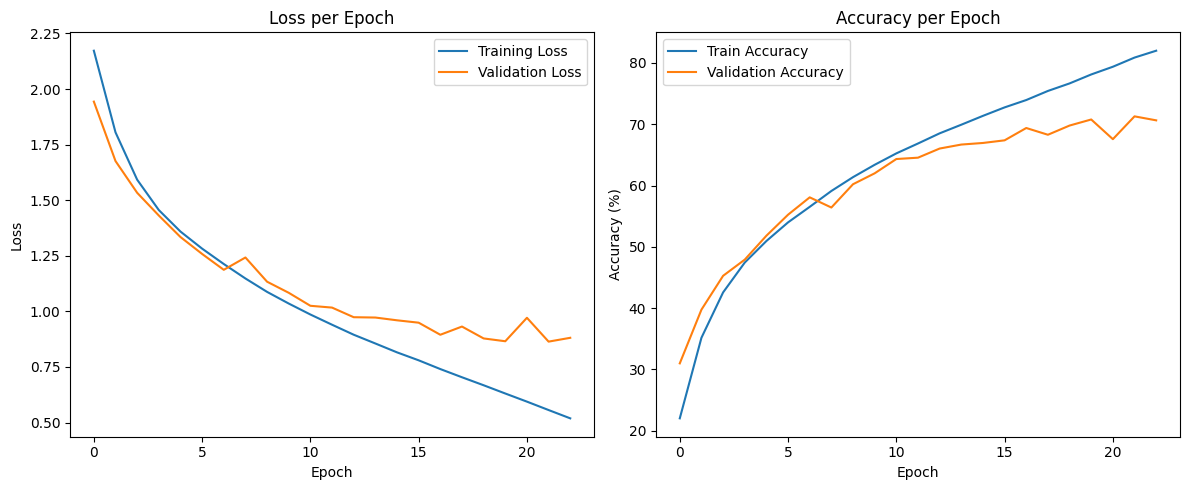

Epoch [24/60], Train Loss: 0.4796, Train Accuracy: 83.28%, Val Loss: 0.8549, Val Accuracy: 71.70%


<Figure size 640x480 with 0 Axes>

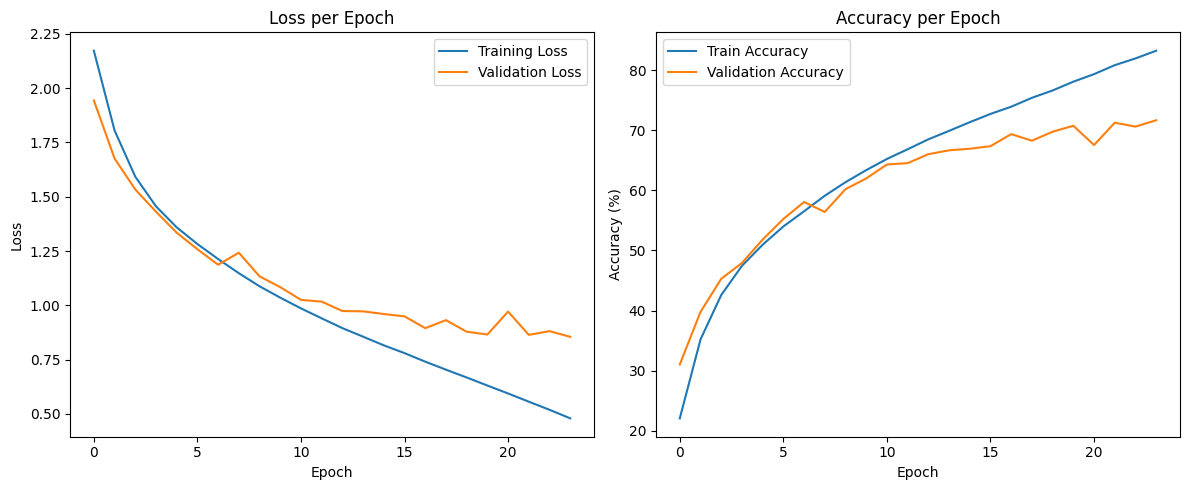

Epoch [25/60], Train Loss: 0.4439, Train Accuracy: 84.69%, Val Loss: 0.9012, Val Accuracy: 70.78%


<Figure size 640x480 with 0 Axes>

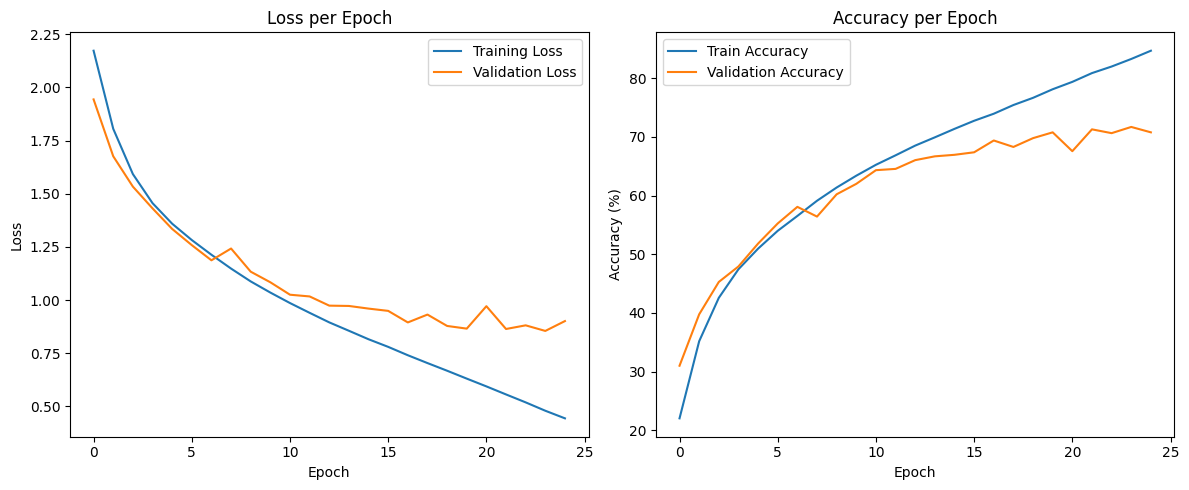

Epoch [26/60], Train Loss: 0.4056, Train Accuracy: 86.27%, Val Loss: 0.8943, Val Accuracy: 71.57%


<Figure size 640x480 with 0 Axes>

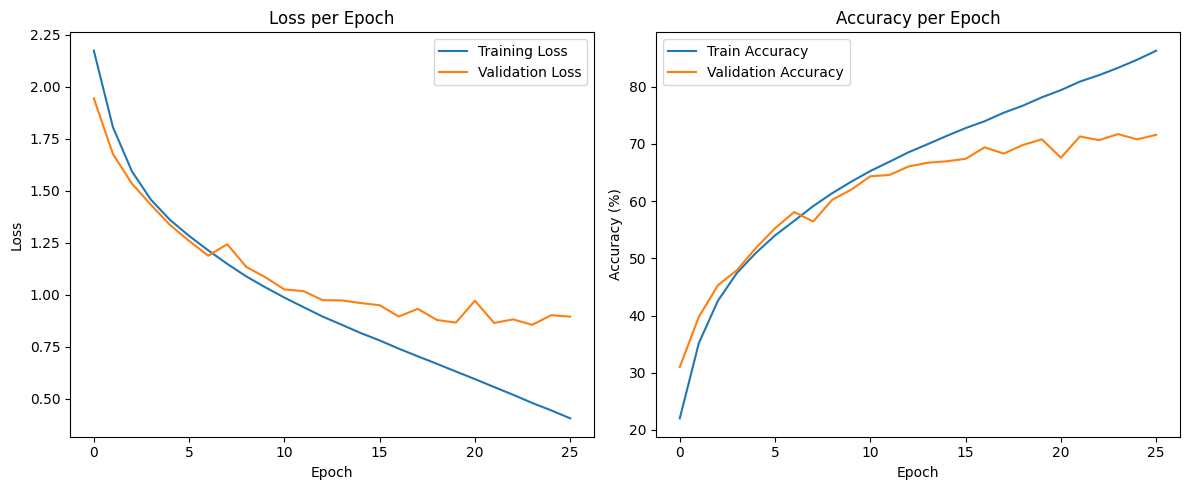

Epoch [27/60], Train Loss: 0.3682, Train Accuracy: 87.39%, Val Loss: 0.9713, Val Accuracy: 70.18%


<Figure size 640x480 with 0 Axes>

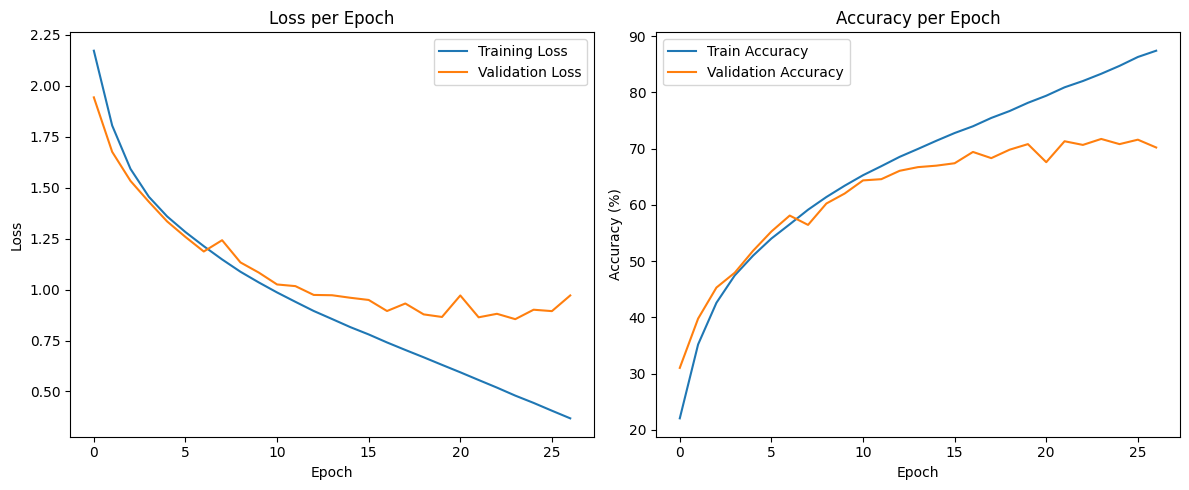

Epoch [28/60], Train Loss: 0.3323, Train Accuracy: 88.81%, Val Loss: 1.0280, Val Accuracy: 70.17%


<Figure size 640x480 with 0 Axes>

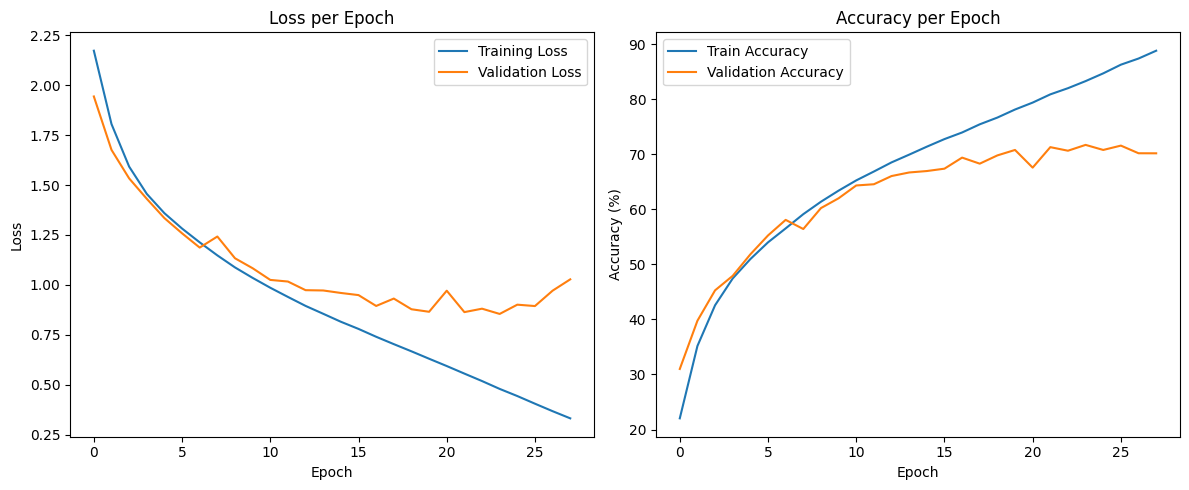

Epoch [29/60], Train Loss: 0.2917, Train Accuracy: 90.39%, Val Loss: 0.9611, Val Accuracy: 71.76%


<Figure size 640x480 with 0 Axes>

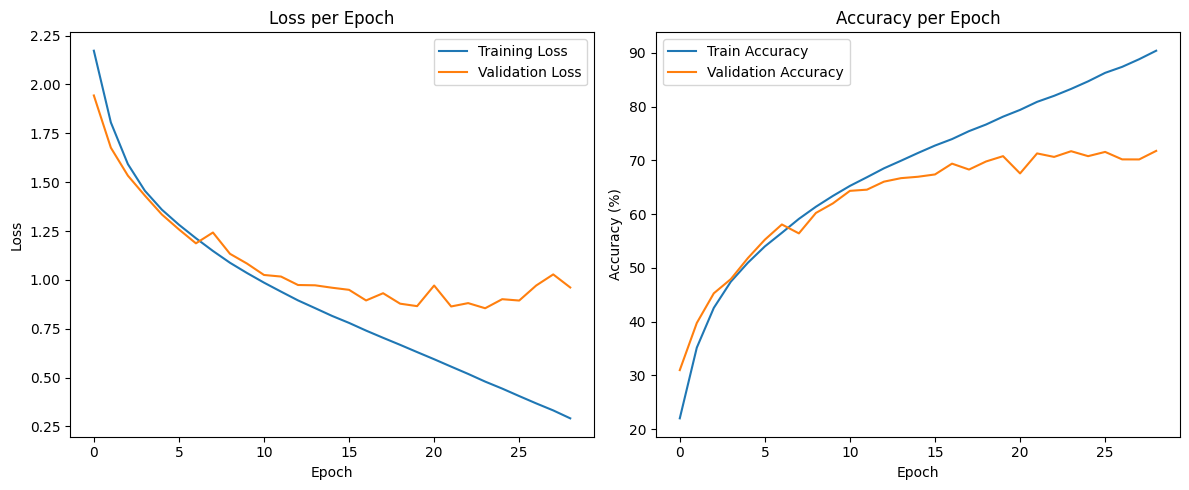

Epoch [30/60], Train Loss: 0.2540, Train Accuracy: 91.70%, Val Loss: 1.0709, Val Accuracy: 69.24%


<Figure size 640x480 with 0 Axes>

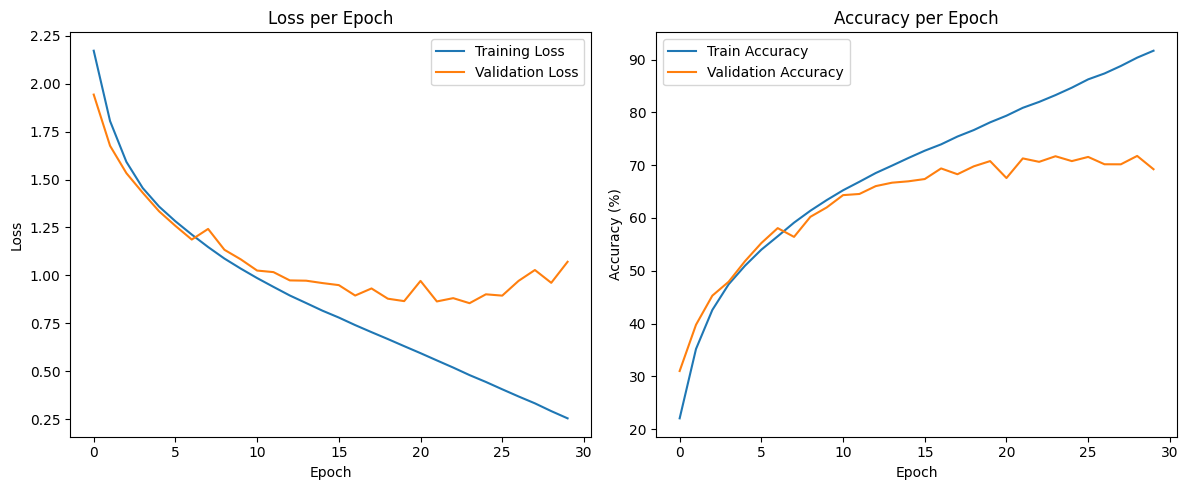

Epoch [31/60], Train Loss: 0.2251, Train Accuracy: 92.73%, Val Loss: 1.0288, Val Accuracy: 70.94%


<Figure size 640x480 with 0 Axes>

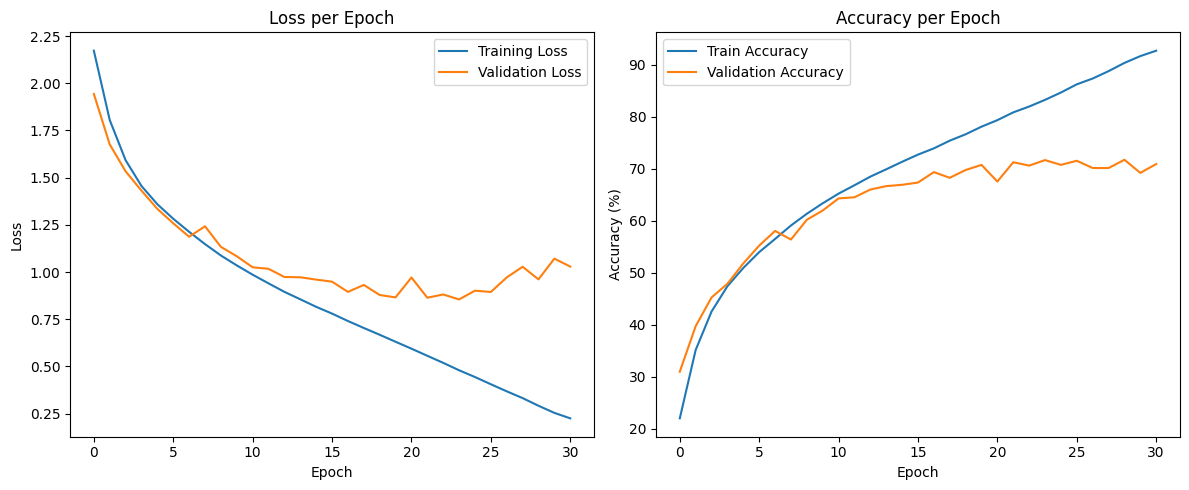

Epoch [32/60], Train Loss: 0.1920, Train Accuracy: 94.05%, Val Loss: 1.0240, Val Accuracy: 72.14%


<Figure size 640x480 with 0 Axes>

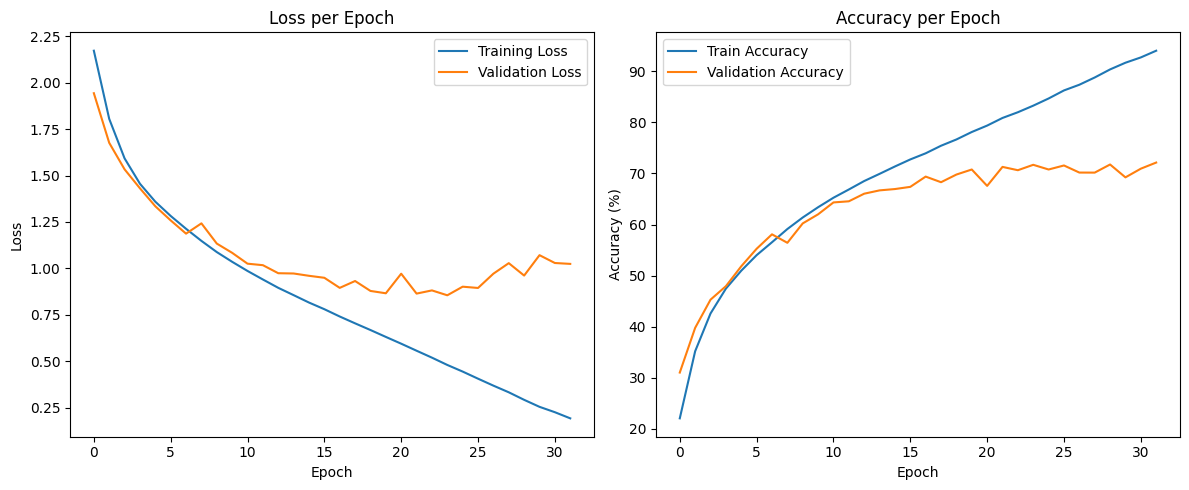

Epoch [33/60], Train Loss: 0.1700, Train Accuracy: 94.86%, Val Loss: 1.0759, Val Accuracy: 71.56%


<Figure size 640x480 with 0 Axes>

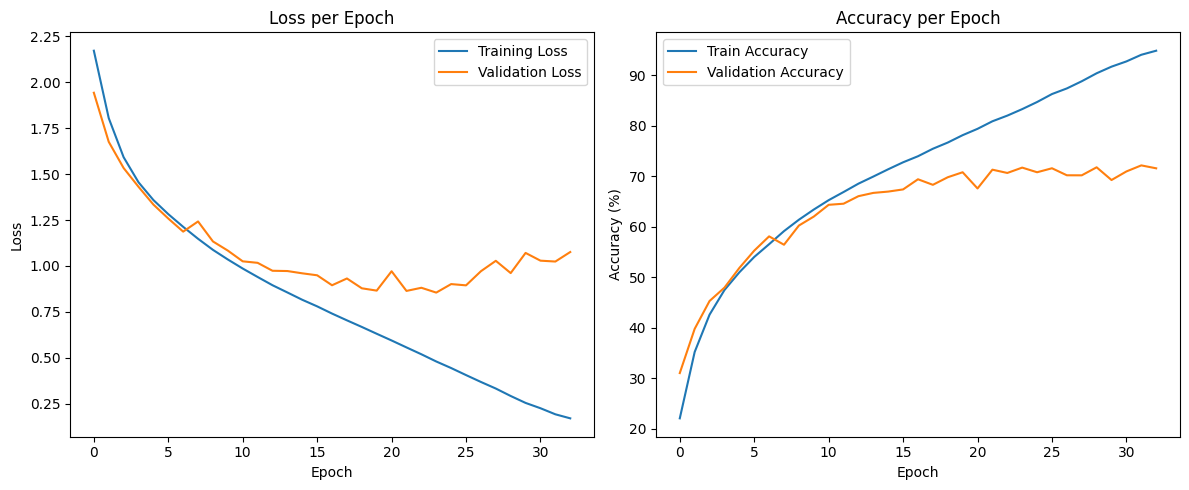

Epoch [34/60], Train Loss: 0.1409, Train Accuracy: 95.81%, Val Loss: 1.1273, Val Accuracy: 71.79%


<Figure size 640x480 with 0 Axes>

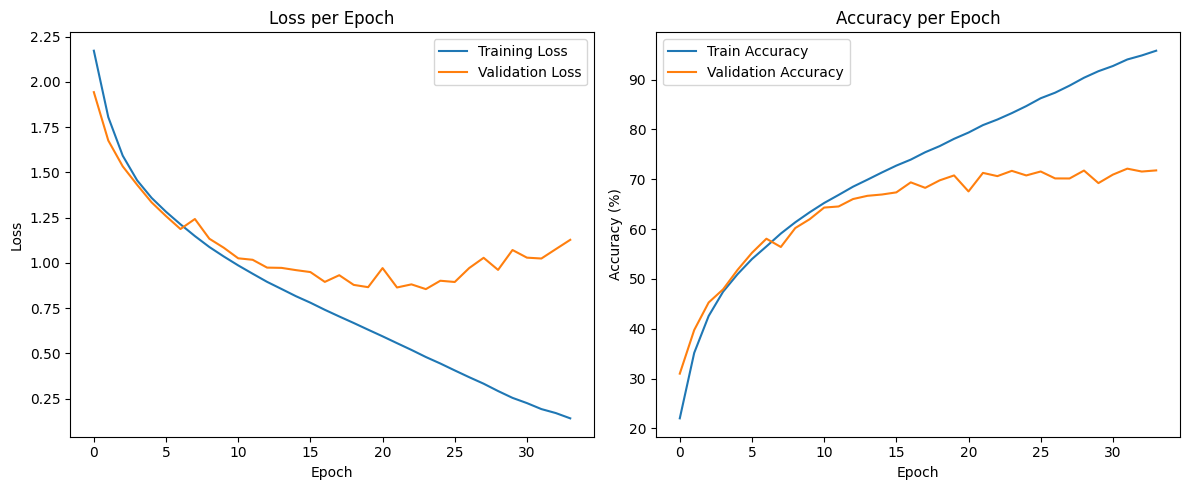

Epoch [35/60], Train Loss: 0.1103, Train Accuracy: 97.09%, Val Loss: 1.2187, Val Accuracy: 70.75%


<Figure size 640x480 with 0 Axes>

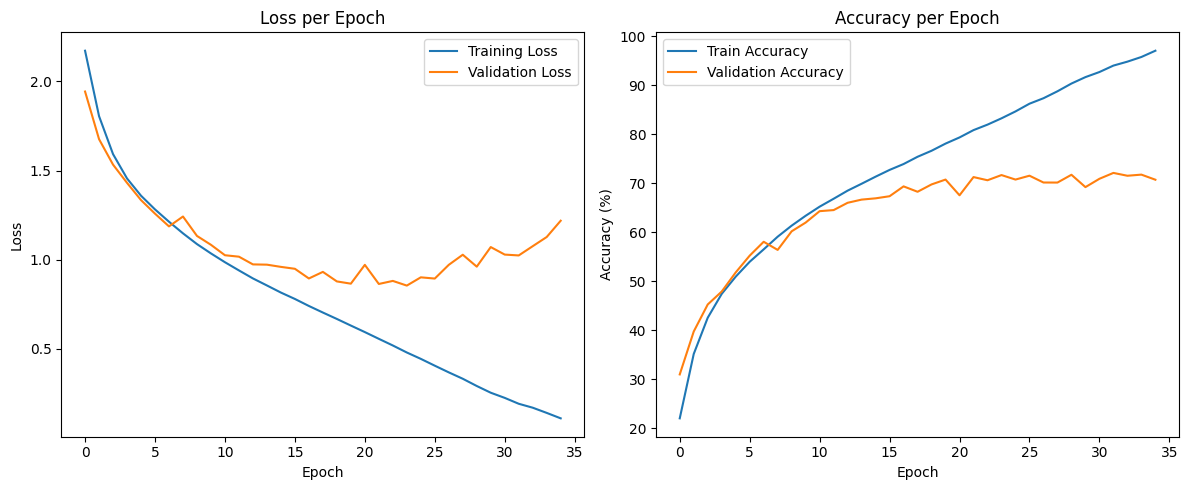

Epoch [36/60], Train Loss: 0.0931, Train Accuracy: 97.83%, Val Loss: 1.2771, Val Accuracy: 70.42%


<Figure size 640x480 with 0 Axes>

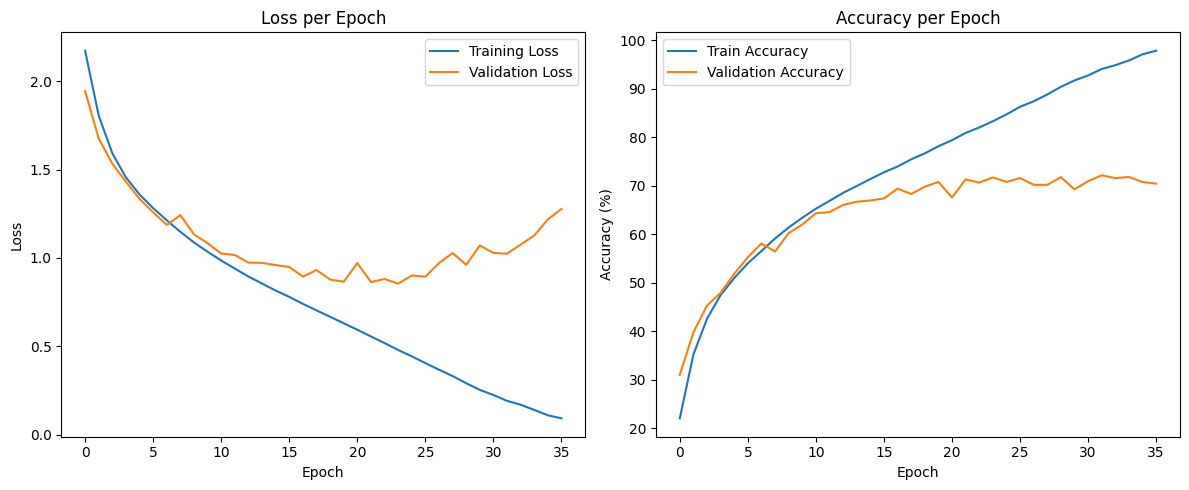

Epoch [37/60], Train Loss: 0.0743, Train Accuracy: 98.41%, Val Loss: 1.2855, Val Accuracy: 70.12%


<Figure size 640x480 with 0 Axes>

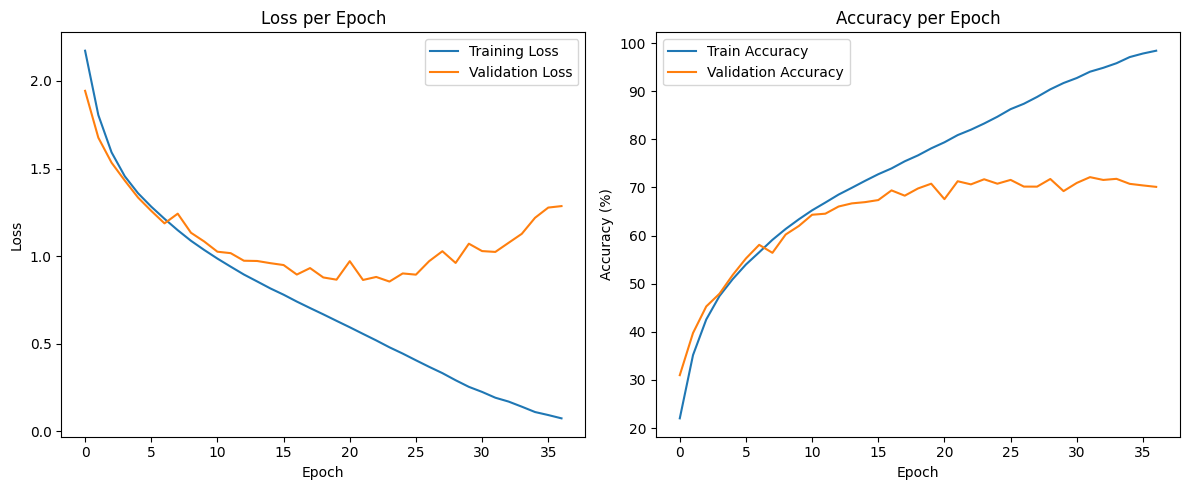

Epoch [38/60], Train Loss: 0.0611, Train Accuracy: 98.78%, Val Loss: 1.2622, Val Accuracy: 71.39%


<Figure size 640x480 with 0 Axes>

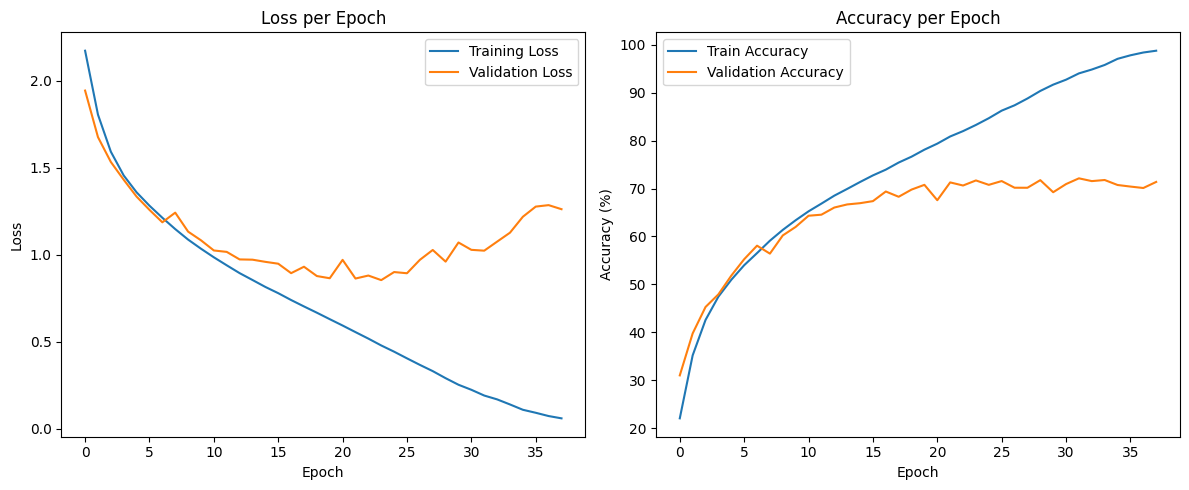

Epoch [39/60], Train Loss: 0.0494, Train Accuracy: 99.25%, Val Loss: 1.2988, Val Accuracy: 71.87%


<Figure size 640x480 with 0 Axes>

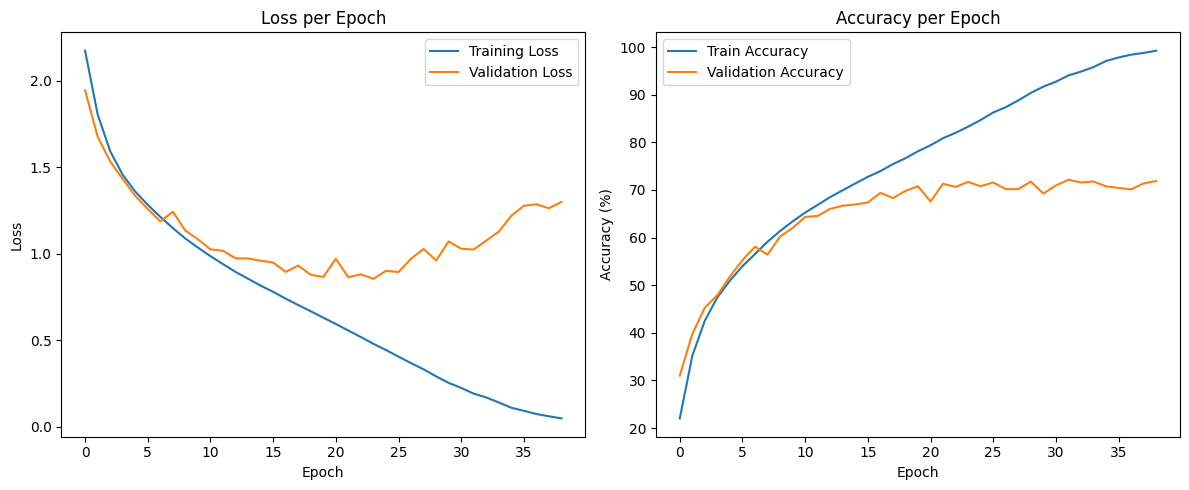

Epoch [40/60], Train Loss: 0.0334, Train Accuracy: 99.58%, Val Loss: 1.3691, Val Accuracy: 72.07%


<Figure size 640x480 with 0 Axes>

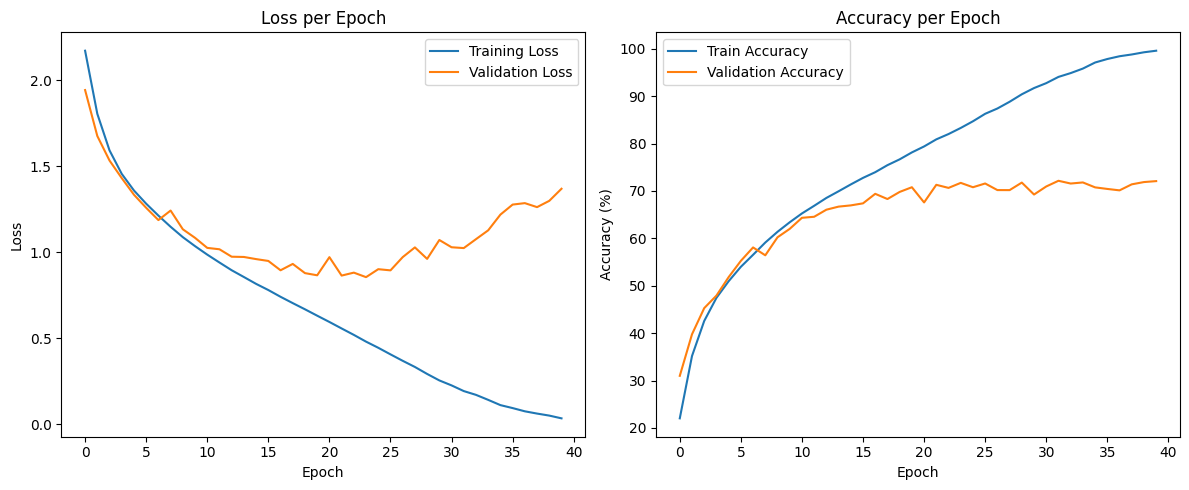

Epoch [41/60], Train Loss: 0.0204, Train Accuracy: 99.87%, Val Loss: 1.4199, Val Accuracy: 72.04%


<Figure size 640x480 with 0 Axes>

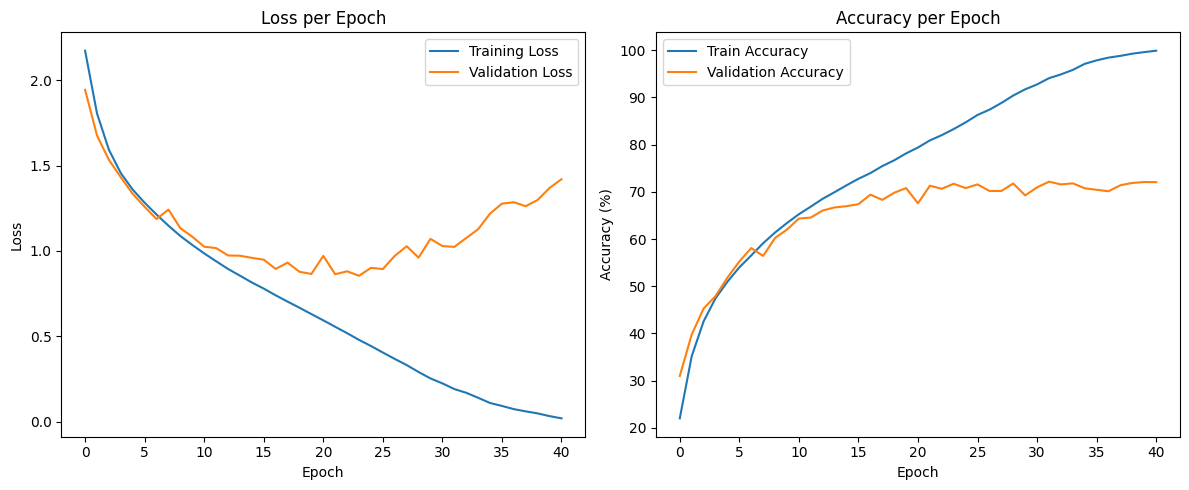

Epoch [42/60], Train Loss: 0.0156, Train Accuracy: 99.92%, Val Loss: 1.4461, Val Accuracy: 72.09%


<Figure size 640x480 with 0 Axes>

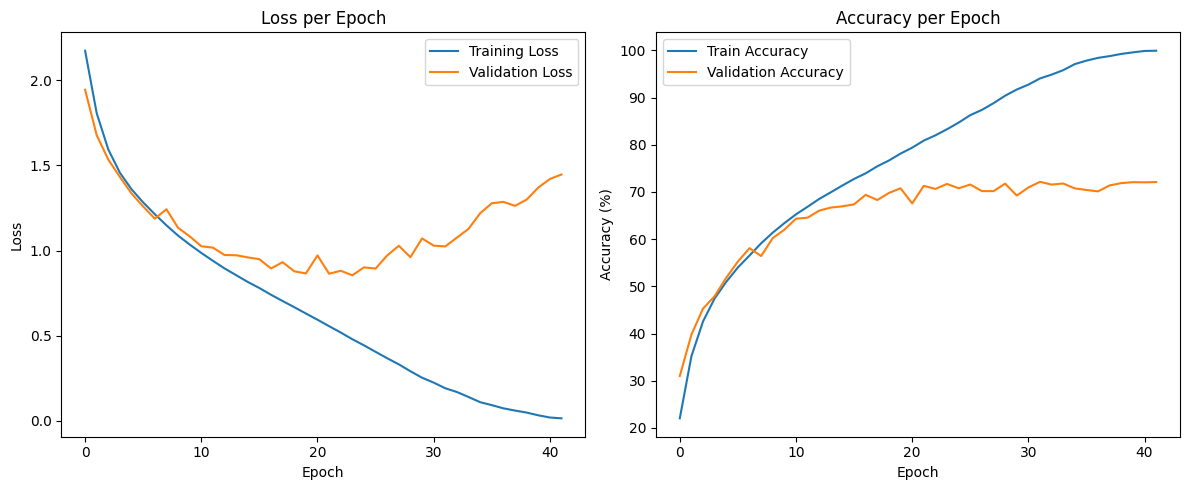

Epoch [43/60], Train Loss: 0.0114, Train Accuracy: 99.97%, Val Loss: 1.4815, Val Accuracy: 71.95%


<Figure size 640x480 with 0 Axes>

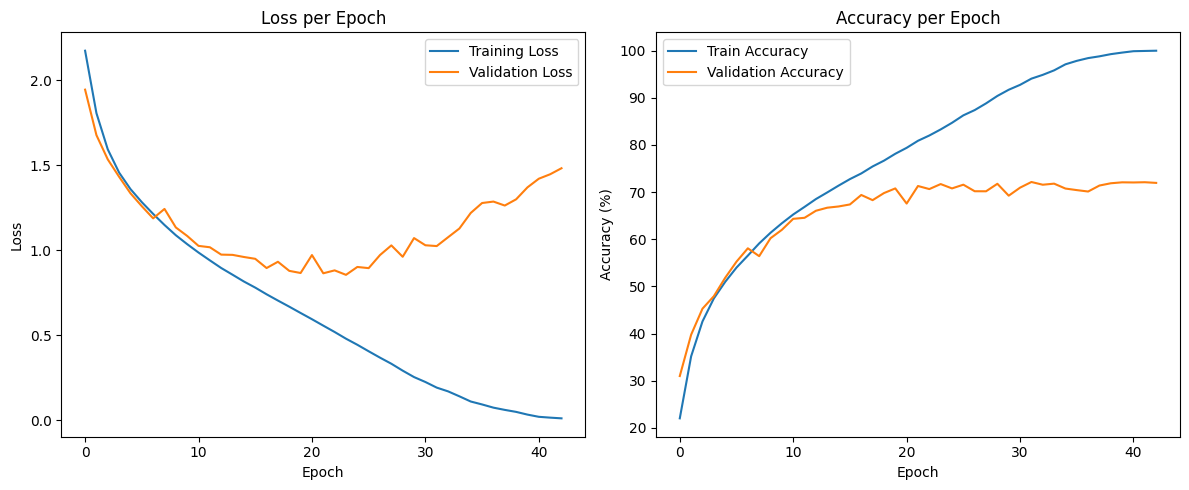

Epoch [44/60], Train Loss: 0.0096, Train Accuracy: 99.95%, Val Loss: 1.5222, Val Accuracy: 72.20%


<Figure size 640x480 with 0 Axes>

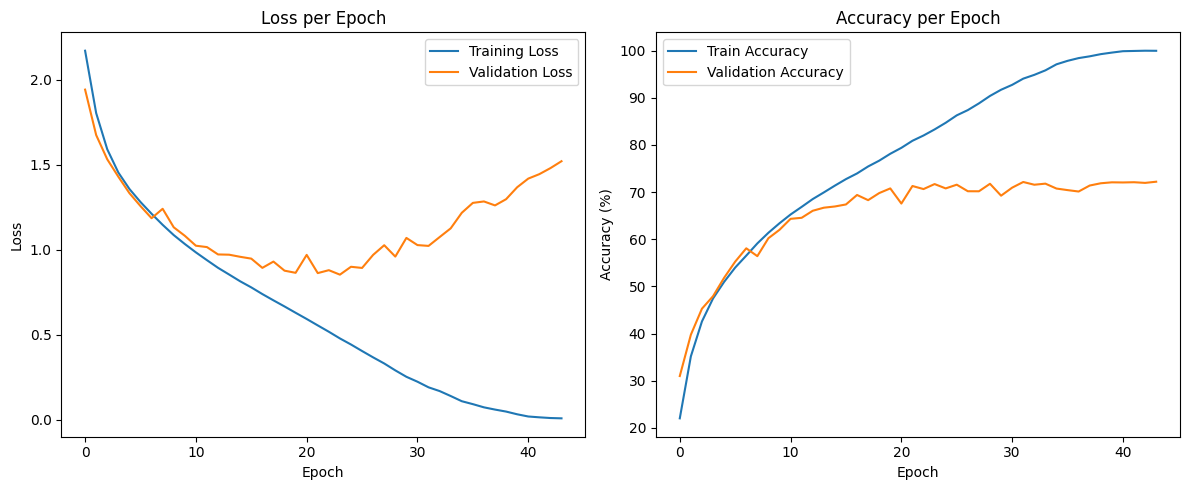

Epoch [45/60], Train Loss: 0.0079, Train Accuracy: 99.98%, Val Loss: 1.5521, Val Accuracy: 71.85%


<Figure size 640x480 with 0 Axes>

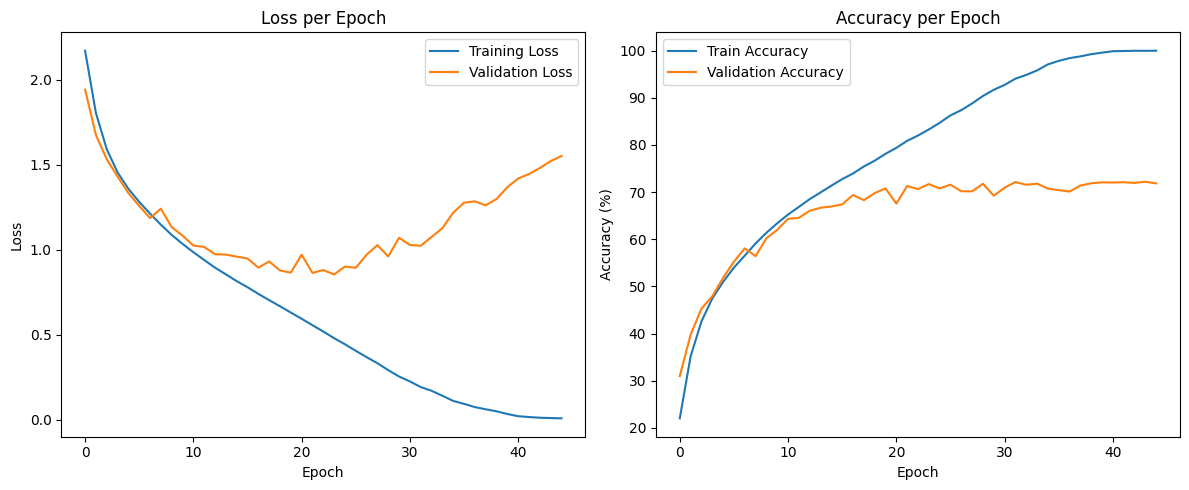

Epoch [46/60], Train Loss: 0.0068, Train Accuracy: 99.99%, Val Loss: 1.5718, Val Accuracy: 72.12%


<Figure size 640x480 with 0 Axes>

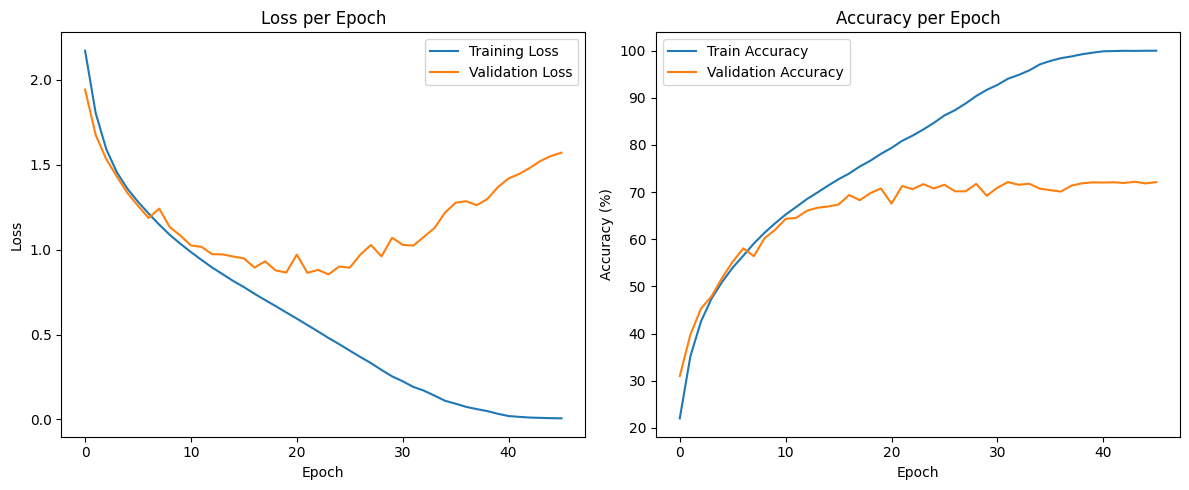

Epoch [47/60], Train Loss: 0.0058, Train Accuracy: 100.00%, Val Loss: 1.5971, Val Accuracy: 72.04%


<Figure size 640x480 with 0 Axes>

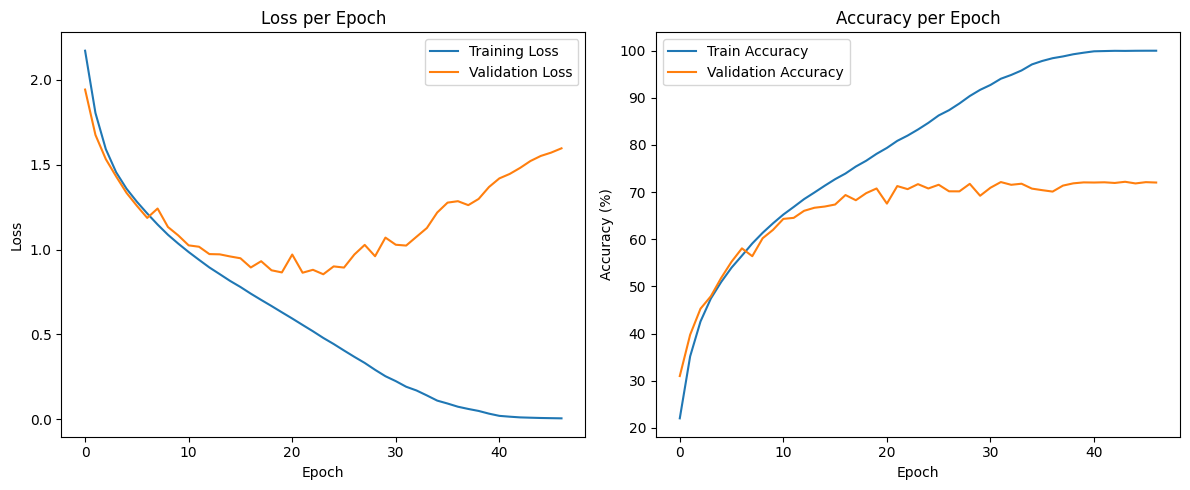

Epoch [48/60], Train Loss: 0.0052, Train Accuracy: 100.00%, Val Loss: 1.6183, Val Accuracy: 72.16%


<Figure size 640x480 with 0 Axes>

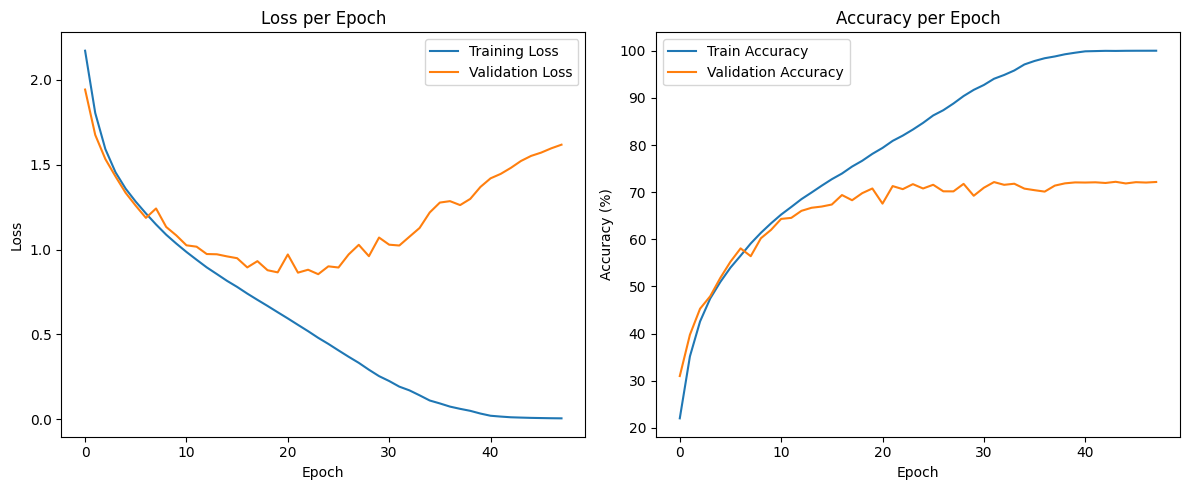

Epoch [49/60], Train Loss: 0.0048, Train Accuracy: 99.99%, Val Loss: 1.6331, Val Accuracy: 72.15%


<Figure size 640x480 with 0 Axes>

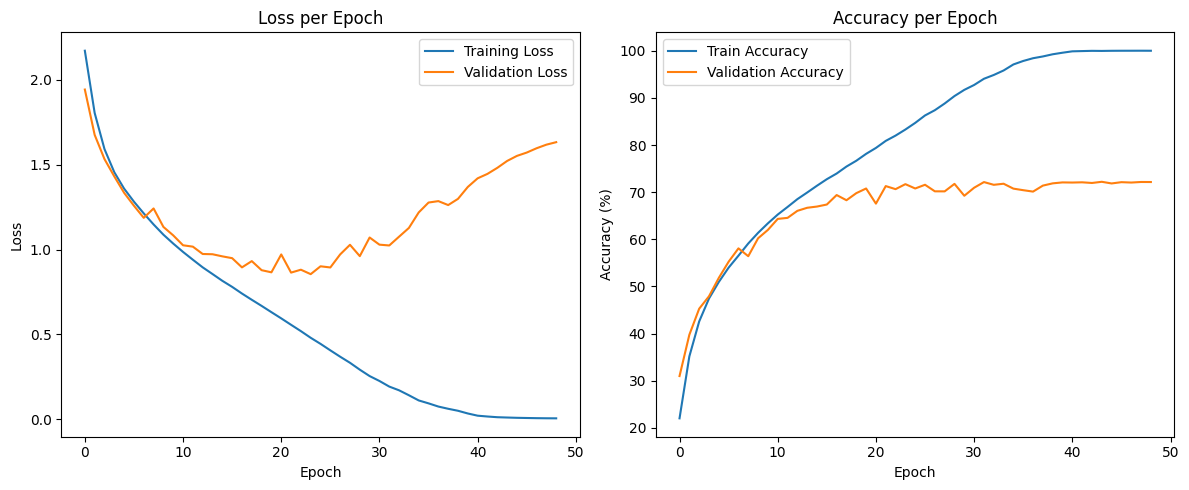

Epoch [50/60], Train Loss: 0.0042, Train Accuracy: 100.00%, Val Loss: 1.6527, Val Accuracy: 72.06%


<Figure size 640x480 with 0 Axes>

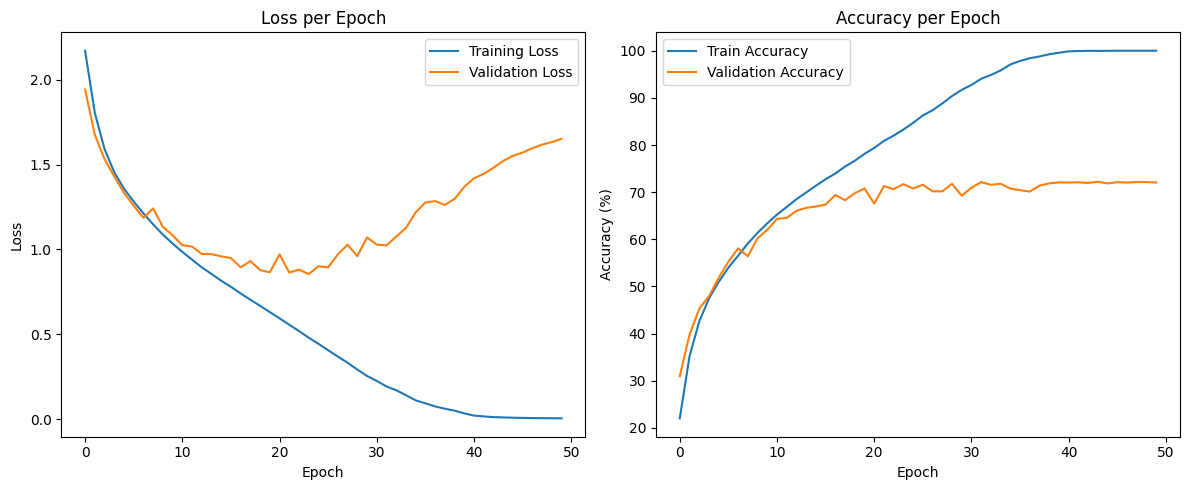

Epoch [51/60], Train Loss: 0.0039, Train Accuracy: 100.00%, Val Loss: 1.6710, Val Accuracy: 71.94%


<Figure size 640x480 with 0 Axes>

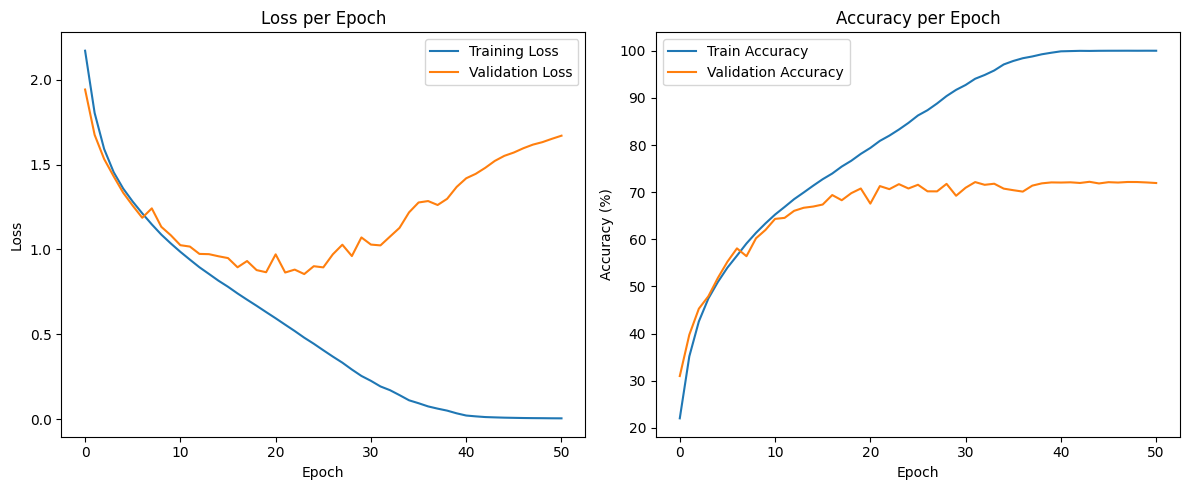

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [ ]:
# ------------------------ MAIN ------------------------
if __name__ == "__main__":
    print("Running Bayesian NAS with Zero-Cost Proxy (GradNorm)...")

    import optuna

    best_score_overall = -float("inf")
    best_params_overall = None
    best_model_overall = None

    # Duyệt từng conv1_out_channels từ 6 đến 64
    for conv1_out_channels in range(6, 65):
        print(f"\n===== Conv1 Out Channels: {conv1_out_channels} =====")

        study = optuna.create_study(direction="maximize")
        study.optimize(lambda trial: objective(trial, conv1_out_channels), n_trials=1)

        # Lưu mô hình tốt nhất nếu điểm cao hơn
        if study.best_value > best_score_overall:
            best_score_overall = study.best_value
            best_params_overall = study.best_params
            best_params_overall['conv1_out_channels'] = conv1_out_channels  # bổ sung thủ công
            best_model_overall = SearchSpace().sample(best_params_overall)

    # Hiển thị kết quả tốt nhất
    print("\n==================== Best Result ====================")
    print(f"Best Proxy Score: {best_score_overall:.4f}")
    print(f"Best Parameters: {best_params_overall}")

    # Hiển thị kiến trúc mô hình tốt nhất
    from torchsummary import summary
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_model_overall.to(device)
    summary(best_model_overall, input_size=(3, 32, 32))

    # Huấn luyện mô hình tốt nhất
    print("\nTraining best model...")
    best_acc = evaluate_architecture(best_model_overall, epochs=60, batch_size=32, lr=0.01)